In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns


In [17]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import os
import json
from datetime import datetime


def create_qc_comparison_report(raw, save_path=None):
    """
    Create a QC report comparing data before and after bad channel marking.
    
    Parameters:
    -----------
    raw : mne.io.Raw
        The raw EEG data with bad channels marked
    save_path : str, optional
        Path to save the QC report figure
    """
    
    # Get good and bad channels
    bad_channels = raw.info['bads']
    good_channels = [ch for ch in raw.ch_names if ch not in bad_channels]
    good_indices = mne.pick_channels(raw.ch_names, good_channels)
    
    # Set up the figure
    fig = plt.figure(figsize=(20, 16))
    gs = GridSpec(4, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    # Get basic info
    sfreq = raw.info['sfreq']
    n_total_channels = len(raw.ch_names)
    n_good_channels = len(good_channels)
    n_bad_channels = len(bad_channels)
    duration = raw.times[-1]
    
    # Title
    fig.suptitle(f'EEG Quality Control - After Bad Channel Marking\n'
                 f'Total Channels: {n_total_channels} | Good: {n_good_channels} | Bad: {n_bad_channels}\n'
                 f'Bad Channels: {", ".join(bad_channels) if bad_channels else "None"}',
                 fontsize=16, fontweight='bold')
    
    # Get data
    all_data = raw.get_data()
    good_data = all_data[good_indices, :]
    
    # 1. Raw data plot - GOOD CHANNELS ONLY
    ax1 = fig.add_subplot(gs[0, :])
    plot_duration = min(10, duration)
    start, stop = 0, int(plot_duration * sfreq)
    
    # Plot good channels
    offset = np.max(np.abs(good_data[:, start:stop])) * 0.5
    times = raw.times[start:stop]
    
    for i, ch_idx in enumerate(good_indices):
        ch_name = raw.ch_names[ch_idx]
        ax1.plot(times, good_data[i, start:stop] - i * offset, 
                linewidth=0.5, alpha=0.8, color='blue')
    
    ax1.set_ylabel('Channels')
    ax1.set_xlabel('Time (s)')
    ax1.set_title(f'Cleaned Data - Good Channels Only (First {plot_duration:.0f} seconds)')
    ax1.set_yticks(-np.arange(n_good_channels) * offset)
    ax1.set_yticklabels(good_channels)
    ax1.grid(True, alpha=0.3)
    ax1.invert_yaxis()
    
    # 2. Before/After variance comparison
    ax2 = fig.add_subplot(gs[1, 0])
    
    # Calculate variance for all channels
    all_var = np.var(all_data, axis=1)
    
    # Create bar plot
    x = np.arange(n_total_channels)
    colors = ['red' if ch in bad_channels else 'blue' for ch in raw.ch_names]
    alphas = [0.3 if ch in bad_channels else 0.8 for ch in raw.ch_names]
    
    bars = ax2.bar(x, all_var, color=colors, alpha=0.8)
    for bar, alpha in zip(bars, alphas):
        bar.set_alpha(alpha)
    
    ax2.set_xlabel('Channel Index')
    ax2.set_ylabel('Variance (μV²)')
    ax2.set_title('Channel Variance (Red = Bad Channels)')
    ax2.grid(True, alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='blue', alpha=0.8, label='Good channels'),
                      Patch(facecolor='red', alpha=0.3, label='Bad channels')]
    ax2.legend(handles=legend_elements)
    
    # 3. PSD comparison
    ax3 = fig.add_subplot(gs[1, 1])
    
    # Compute PSD for good channels only
    psd_good, freqs = mne.time_frequency.psd_array_welch(
        good_data, sfreq=sfreq, fmin=0.5, fmax=50, n_fft=int(sfreq*2)
    )
    
    # If there are bad channels, compute their PSD for comparison
    if bad_channels:
        bad_indices = mne.pick_channels(raw.ch_names, bad_channels)
        bad_data = all_data[bad_indices, :]
        psd_bad, _ = mne.time_frequency.psd_array_welch(
            bad_data, sfreq=sfreq, fmin=0.5, fmax=50, n_fft=int(sfreq*2)
        )
        
        # Plot bad channels PSD
        mean_psd_bad = np.mean(10 * np.log10(psd_bad), axis=0)
        ax3.plot(freqs, mean_psd_bad, 'r-', alpha=0.5, linewidth=2, 
                label=f'Bad channels (n={n_bad_channels})')
    
    # Plot good channels PSD
    mean_psd_good = np.mean(10 * np.log10(psd_good), axis=0)
    std_psd_good = np.std(10 * np.log10(psd_good), axis=0)
    
    ax3.plot(freqs, mean_psd_good, 'b-', linewidth=2, label=f'Good channels (n={n_good_channels})')
    ax3.fill_between(freqs, mean_psd_good - std_psd_good, mean_psd_good + std_psd_good, 
                     alpha=0.3, color='blue')
    
    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_ylabel('Power (dB)')
    ax3.set_title('Power Spectral Density Comparison')
    ax3.set_xlim(0, 50)
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # 4. Good channels correlation matrix
    ax4 = fig.add_subplot(gs[1, 2])
    
    # Compute correlation for good channels only
    subset_good_data = good_data[:, ::10]
    corr_matrix_good = np.corrcoef(subset_good_data)
    
    im = ax4.imshow(corr_matrix_good, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
    ax4.set_xlabel('Good Channel Index')
    ax4.set_ylabel('Good Channel Index')
    ax4.set_title('Correlation Matrix - Good Channels Only')
    plt.colorbar(im, ax=ax4, fraction=0.046, pad=0.04)
    
    # 5. Amplitude distribution comparison
    ax5 = fig.add_subplot(gs[2, 0])
    
    # Sample data
    sample_good = good_data[:, ::100].flatten()
    
    # Plot histogram for good channels
    ax5.hist(sample_good, bins=100, alpha=0.7, color='blue', density=True, 
             label='Good channels')
    
    # If there are bad channels, plot their distribution
    if bad_channels:
        sample_bad = bad_data[:, ::100].flatten()
        ax5.hist(sample_bad, bins=100, alpha=0.5, color='red', density=True, 
                label='Bad channels')
    
    ax5.set_xlabel('Amplitude (μV)')
    ax5.set_ylabel('Density')
    ax5.set_title('Amplitude Distribution Comparison')
    ax5.grid(True, alpha=0.3)
    ax5.legend()
    
    # 6. Time-based RMS - good channels only
    ax6 = fig.add_subplot(gs[2, 1])
    
    window_size = int(sfreq)  # 1-second windows
    n_windows = good_data.shape[1] // window_size
    rms_over_time = []
    time_points = []
    
    for i in range(n_windows):
        start_idx = i * window_size
        end_idx = (i + 1) * window_size
        window_data = good_data[:, start_idx:end_idx]
        rms = np.sqrt(np.mean(window_data**2, axis=1))
        rms_over_time.append(np.mean(rms))
        time_points.append(raw.times[start_idx])
    
    ax6.plot(time_points, rms_over_time, 'b-', linewidth=2)
    ax6.set_xlabel('Time (s)')
    ax6.set_ylabel('Mean RMS (μV)')
    ax6.set_title('Signal RMS Over Time - Good Channels Only')
    ax6.grid(True, alpha=0.3)
    
    # 7. Signal quality metrics
    ax7 = fig.add_subplot(gs[2, 2])
    
    # Calculate SNR estimate (signal power / noise power)
    # Using 1-4 Hz as noise estimate and 8-13 Hz as signal estimate
    psd_good_full, freqs_full = mne.time_frequency.psd_array_welch(
        good_data, sfreq=sfreq, fmin=0.1, fmax=50, n_fft=int(sfreq*4)
    )
    
    noise_band = (freqs_full >= 1) & (freqs_full <= 4)
    signal_band = (freqs_full >= 8) & (freqs_full <= 13)
    
    noise_power = np.mean(psd_good_full[:, noise_band], axis=1)
    signal_power = np.mean(psd_good_full[:, signal_band], axis=1)
    snr_per_channel = 10 * np.log10(signal_power / noise_power)
    
    ax7.bar(range(len(snr_per_channel)), snr_per_channel, color='green', alpha=0.7)
    ax7.set_xlabel('Good Channel Index')
    ax7.set_ylabel('SNR (dB)')
    ax7.set_title('Signal-to-Noise Ratio per Channel\n(Alpha/Low-frequency ratio)')
    ax7.grid(True, alpha=0.3)
    ax7.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    # 8. Bad segments on good channels
    ax8 = fig.add_subplot(gs[3, :2])
    
    # Detect high amplitude segments in good channels only
    threshold = np.percentile(np.abs(good_data), 99.9)
    bad_segments = np.any(np.abs(good_data) > threshold, axis=0)
    
    ax8.plot(raw.times[:len(bad_segments)], np.max(np.abs(good_data), axis=0), 
             'b-', linewidth=0.5, alpha=0.7)
    ax8.fill_between(raw.times[:len(bad_segments)], 0, 
                     np.max(np.abs(good_data), axis=0) * bad_segments,
                     color='red', alpha=0.5, label='High amplitude segments')
    ax8.set_xlabel('Time (s)')
    ax8.set_ylabel('Max Absolute Amplitude (μV)')
    ax8.set_title('Potential Bad Segments - Good Channels Only')
    ax8.grid(True, alpha=0.3)
    ax8.legend()
    
    # 9. Summary statistics
    ax9 = fig.add_subplot(gs[3, 2])
    ax9.axis('off')
    
    # Calculate statistics
    mean_snr = np.mean(snr_per_channel)
    stats_text = f"""
    Data Quality Summary:
    
    Channel Statistics:
    Total channels: {n_total_channels}
    Good channels: {n_good_channels}
    Bad channels: {n_bad_channels}
    
    Good Channels Signal Stats:
    Mean amplitude: {np.mean(good_data):.2f} μV
    Std amplitude: {np.std(good_data):.2f} μV
    Min amplitude: {np.min(good_data):.2f} μV
    Max amplitude: {np.max(good_data):.2f} μV
    
    Quality Metrics:
    Mean SNR: {mean_snr:.2f} dB
    Bad segments: {np.sum(bad_segments)/len(bad_segments)*100:.1f}%
    Mean correlation: {np.mean(corr_matrix_good[np.triu_indices_from(corr_matrix_good, k=1)]):.3f}
    
    Improvement:
    Variance reduction: {(1 - np.var(good_data)/np.var(all_data))*100:.1f}%
    """
    
    ax9.text(0.1, 0.9, stats_text, transform=ax9.transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"QC report saved to: {save_path}")
    
    return fig, {
        'bad_channels': bad_channels,
        'good_channels': good_channels,
        'mean_snr': mean_snr,
        'bad_segments_ratio': np.sum(bad_segments)/len(bad_segments),
        'variance_reduction': (1 - np.var(good_data)/np.var(all_data))*100
    }


def automated_channel_cleaning(raw, ecg_channel_names=None, z_score_threshold=5.0, 
                              correlation_threshold=0.2, powerline_threshold=15.0,
                              save_report=True, report_path=None):
    """
    Automated EEG channel cleaning: removes ECG channels and detects bad channels.
    
    Parameters:
    -----------
    raw : mne.io.Raw
        The raw EEG data
    ecg_channel_names : list or None
        Names of ECG channels to remove. If None, will search for common ECG channel names
    z_score_threshold : float
        Z-score threshold for variance-based bad channel detection
    correlation_threshold : float
        Minimum correlation threshold with neighboring channels
    powerline_threshold : float
        Threshold for 50/60 Hz power relative to surrounding frequencies
    save_report : bool
        Whether to save the QC report
    report_path : str
        Path to save the report (auto-generated if None)
    
    Returns:
    --------
    raw_clean : mne.io.Raw
        Cleaned raw data with bad channels marked/removed
    bad_channels : list
        List of detected bad channels
    qc_stats : dict
        Quality control statistics
    """
    
    # Common ECG channel name patterns
    ecg_patterns = ['ECG', 'EKG', 'ecg', 'ekg', 'ECG1', 'ECG2', 'EKG1', 'EKG2']
    
    # Find and remove ECG channels
    ecg_channels_found = []
    if ecg_channel_names is None:
        # Search for ECG channels by name patterns
        for ch_name in raw.ch_names:
            if any(pattern in ch_name for pattern in ecg_patterns):
                ecg_channels_found.append(ch_name)
    else:
        ecg_channels_found = ecg_channel_names
    
    # Remove ECG channels
    if ecg_channels_found:
        print(f"Removing ECG channels: {ecg_channels_found}")
        raw = raw.copy().drop_channels(ecg_channels_found)
    else:
        print("No ECG channels found to remove")
        raw = raw.copy()
    
    # Automated bad channel detection
    print("\nPerforming automated bad channel detection...")
    
    # Get data for analysis
    data = raw.get_data()
    sfreq = raw.info['sfreq']
    
    bad_channels = []
    
    # 1. Variance-based detection (too noisy or flat channels)
    channel_vars = np.var(data, axis=1)
    z_scores = np.abs((channel_vars - np.median(channel_vars)) / np.median(channel_vars))
    
    # Mark channels with extreme variance
    bad_by_variance = []
    for idx, (z_score, ch_name) in enumerate(zip(z_scores, raw.ch_names)):
        if z_score > z_score_threshold:
            bad_by_variance.append(ch_name)
            print(f"  - {ch_name}: High variance (z-score: {z_score:.2f})")
        elif channel_vars[idx] < np.median(channel_vars) * 0.01:  # Nearly flat channels
            bad_by_variance.append(ch_name)
            print(f"  - {ch_name}: Nearly flat (variance: {channel_vars[idx]:.2e})")
    
    bad_channels.extend(bad_by_variance)
    
    # 2. Correlation-based detection (channels uncorrelated with neighbors)
    print("\nChecking channel correlations...")
    
    # Compute correlation matrix
    downsampled_data = data[:, ::10]  # Downsample for faster computation
    corr_matrix = np.corrcoef(downsampled_data)
    
    # For each channel, check correlation with others
    bad_by_correlation = []
    for idx, ch_name in enumerate(raw.ch_names):
        if ch_name in bad_channels:
            continue
            
        # Get correlations with other channels (excluding self)
        correlations = corr_matrix[idx, :]
        correlations[idx] = 0  # Exclude self-correlation
        
        # Calculate mean absolute correlation
        mean_corr = np.mean(np.abs(correlations))
        
        if mean_corr < correlation_threshold:
            bad_by_correlation.append(ch_name)
            print(f"  - {ch_name}: Low correlation with other channels (mean: {mean_corr:.2f})")
    
    bad_channels.extend(bad_by_correlation)
    
    # 3. Powerline noise detection
    print("\nChecking for excessive powerline noise...")
    
    # Compute PSD for each channel
    from mne.time_frequency import psd_array_welch
    psds, freqs = psd_array_welch(data, sfreq=sfreq, fmin=1, fmax=100, n_fft=int(sfreq*2))
    
    # Check for 50 Hz or 60 Hz peaks
    bad_by_powerline = []
    for idx, ch_name in enumerate(raw.ch_names):
        if ch_name in bad_channels:
            continue
            
        # Find powerline frequency (50 or 60 Hz)
        idx_50 = np.argmin(np.abs(freqs - 50))
        idx_60 = np.argmin(np.abs(freqs - 60))
        
        # Check surrounding frequencies
        power_50 = psds[idx, idx_50]
        power_60 = psds[idx, idx_60]
        
        # Compare to surrounding frequencies
        surrounding_50 = np.mean(psds[idx, max(0, idx_50-5):idx_50+5])
        surrounding_60 = np.mean(psds[idx, max(0, idx_60-5):idx_60+5])
        
        ratio_50 = power_50 / (surrounding_50 + 1e-10)
        ratio_60 = power_60 / (surrounding_60 + 1e-10)
        
        if ratio_50 > powerline_threshold or ratio_60 > powerline_threshold:
            bad_by_powerline.append(ch_name)
            print(f"  - {ch_name}: Excessive powerline noise (50Hz ratio: {ratio_50:.1f}, 60Hz ratio: {ratio_60:.1f})")
    
    bad_channels.extend(bad_by_powerline)
    
    # 4. Additional checks using MNE's methods
    try:
        # Local Outlier Factor method
        from mne.preprocessing import find_bad_channels_lof
        lof_bads = find_bad_channels_lof(raw, n_neighbors=min(5, len(raw.ch_names)//4))
        for ch in lof_bads:
            if ch not in bad_channels:
                bad_channels.append(ch)
                print(f"  - {ch}: Detected by Local Outlier Factor method")
    except Exception as e:
        print(f"LOF method failed: {e}")
    
    # Remove duplicates
    bad_channels = list(set(bad_channels))
    
    # Mark bad channels
    raw.info['bads'] = bad_channels
    
    print(f"\nTotal bad channels detected: {len(bad_channels)}")
    print(f"Bad channels: {bad_channels}")
    
    # Generate QC report
    if report_path is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        report_path = f'eeg_qc_report_{timestamp}.png'
    
    fig, qc_stats = create_qc_comparison_report(raw, save_path=report_path if save_report else None)
    
    # Add detection method information to stats
    qc_stats['bad_by_variance'] = bad_by_variance
    qc_stats['bad_by_correlation'] = bad_by_correlation
    qc_stats['bad_by_powerline'] = bad_by_powerline
    qc_stats['ecg_channels_removed'] = ecg_channels_found
    
    return raw, bad_channels, qc_stats


## Literature-based balanced thresholds
#raw_processed, info = process_eeg_file(
#    filepath,
#    interpolate_bads=False,
#    z_score_threshold=4.0,      # FASTER/FieldTrip standard
#    correlation_threshold=0.3,   # Slightly relaxed from PREP's 0.4
#    powerline_threshold=12.0    # Moderate threshold
#)

# For clinical or noisy data, use more relaxed thresholds
#raw_processed, info = process_eeg_file(
#    filepath,
#    interpolate_bads=False,
#    z_score_threshold=5.0,      # More tolerant
##    correlation_threshold=0.25,  # More relaxed
 #   powerline_threshold=15.0    # More tolerant
#)

def process_eeg_file(filepath, output_dir=None, interpolate_bads=False, 
                     z_score_threshold=4.0, correlation_threshold=0.3, 
                     powerline_threshold=12.0):
    """
    Complete automated processing pipeline for a single EEG file.
    
    Parameters:
    -----------
    filepath : str
        Path to the EEG file
    output_dir : str
        Directory to save processed files (uses current directory if None)
    interpolate_bads : bool
        Whether to interpolate bad channels instead of removing them
    
    Returns:
    --------
    raw_processed : mne.io.Raw
        Processed EEG data
    processing_info : dict
        Information about the processing steps
    """
    
    # Set output directory
    if output_dir is None:
        output_dir = os.path.dirname(filepath)
    
    # Create output subdirectory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_subdir = os.path.join(output_dir, f'processed_{timestamp}')
    os.makedirs(output_subdir, exist_ok=True)
    
    # Load data
    print(f"Loading EEG data from: {filepath}")
    raw = mne.io.read_raw_edf(filepath, preload=True)
    
    # Store original info
    original_n_channels = len(raw.ch_names)
    
    # Run automated cleaning
    raw_cleaned, bad_channels, qc_stats = automated_channel_cleaning(
        raw, 
        z_score_threshold=z_score_threshold,
        correlation_threshold=correlation_threshold,
        powerline_threshold=powerline_threshold,
        save_report=True,
        report_path=os.path.join(output_subdir, 'qc_report.png')
    )
    
    # Process bad channels
    if interpolate_bads and len(bad_channels) > 0:
        print(f"\nInterpolating {len(bad_channels)} bad channels...")
        raw_processed = raw_cleaned.copy()
        raw_processed.interpolate_bads(reset_bads=False)
        processing_method = 'interpolated'
    else:
        print(f"\nRemoving {len(bad_channels)} bad channels...")
        good_channels = [ch for ch in raw_cleaned.ch_names if ch not in bad_channels]
        raw_processed = raw_cleaned.copy().pick_channels(good_channels)
        processing_method = 'removed'
    
    # Save processed data
    output_fif = os.path.join(output_subdir, 'processed_data.fif')
    raw_processed.save(output_fif, overwrite=True)
    print(f"\nProcessed data saved to: {output_fif}")
    
    # Save processing info
    processing_info = {
        'timestamp': timestamp,
        'original_file': filepath,
        'original_n_channels': original_n_channels,
        'ecg_removed': qc_stats['ecg_channels_removed'],
        'bad_channels': bad_channels,
        'bad_channel_method': processing_method,
        'final_n_channels': len(raw_processed.ch_names),
        'qc_stats': qc_stats
    }
    
    # Save processing info as JSON
    info_path = os.path.join(output_subdir, 'processing_info.json')
    with open(info_path, 'w') as f:
        json.dump(processing_info, f, indent=4)
    
    print(f"\nProcessing complete!")
    print(f"Original channels: {original_n_channels}")
    print(f"ECG removed: {len(qc_stats['ecg_channels_removed'])}")
    print(f"Bad channels detected: {len(bad_channels)}")
    print(f"Final channels: {len(raw_processed.ch_names)}")
    print(f"\nAll outputs saved to: {output_subdir}")
    
    return raw_processed, processing_info


Loading EEG data from: ../BVAnalyzer/export/sub-dmnelf006_task-feedback-run02.edf
Extracting EDF parameters from /Users/cccbauer/Documents/GitHub/rt-BPD/analysis/BVAnalyzer/export/sub-dmnelf006_task-feedback-run02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 37499  =      0.000 ...   149.996 secs...
Removing ECG channels: ['ECG']

Performing automated bad channel detection...

Checking channel correlations...

Checking for excessive powerline noise...
Effective window size : 2.000 (s)
LOF: Detected bad channel(s): ['Fp1', 'TP9']
  - Fp1: Detected by Local Outlier Factor method
  - TP9: Detected by Local Outlier Factor method

Total bad channels detected: 2
Bad channels: ['TP9', 'Fp1']
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 4.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/var/folders/9y/y6xh07m50kb7jt9df0d41trr0000gp/T/ipykernel_609/1902956911.py

QC report saved to: ../BVAnalyzer/export/processed_20250813_124329/qc_report.png

Removing 2 bad channels...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Writing /Users/cccbauer/Documents/GitHub/rt-BPD/analysis/MNE/../BVAnalyzer/export/processed_20250813_124329/processed_data.fif
Closing /Users/cccbauer/Documents/GitHub/rt-BPD/analysis/MNE/../BVAnalyzer/export/processed_20250813_124329/processed_data.fif
[done]

Processed data saved to: ../BVAnalyzer/export/processed_20250813_124329/processed_data.fif

Processing complete!
Original channels: 32
ECG removed: 1
Bad channels detected: 2
Final channels: 29

All outputs saved to: ../BVAnalyzer/export/processed_20250813_124329


/var/folders/9y/y6xh07m50kb7jt9df0d41trr0000gp/T/ipykernel_609/1902956911.py:536: RuntimeWarning: This filename (/Users/cccbauer/Documents/GitHub/rt-BPD/analysis/MNE/../BVAnalyzer/export/processed_20250813_124329/processed_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_processed.save(output_fif, overwrite=True)


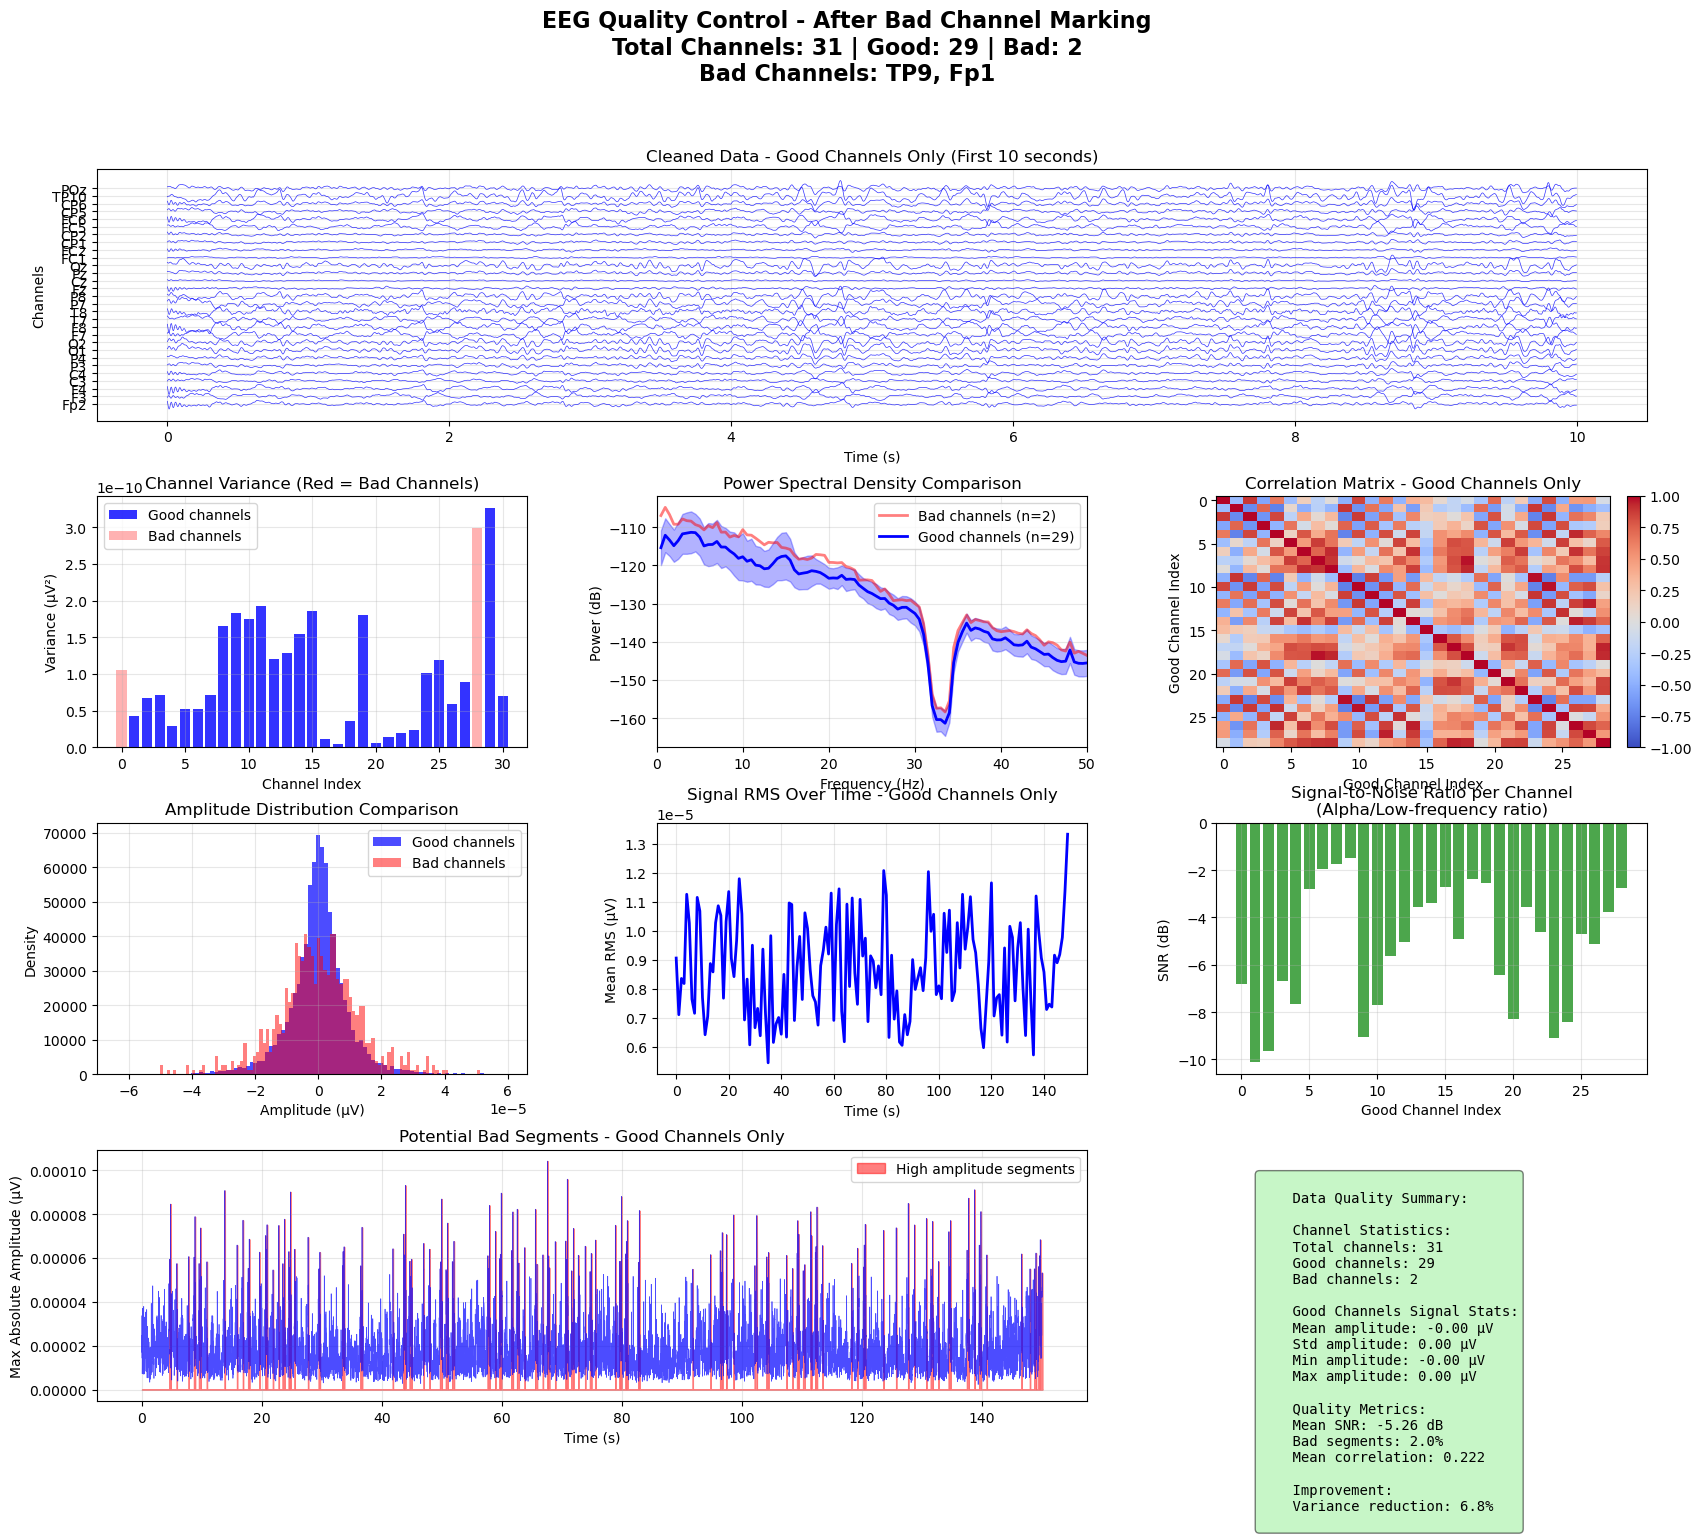

In [18]:


# Example usage:
if __name__ == "__main__":
    # Process a single file
    #filepath = '../BVAnalyzer/export/sub-rtbpd003_ses-nf2_task_feedback_run-01_cleaned.edf'
    filepath = '../BVAnalyzer/export/sub-dmnelf006_task-feedback-run02.edf'
    
    # Option 1: Remove bad channels (with more lenient thresholds)
    raw_processed, info = process_eeg_file(filepath, interpolate_bads=False,
                                          z_score_threshold=5.0,
                                          correlation_threshold=0.2,
                                          powerline_threshold=15.0)
    
    # Option 2: Even more lenient thresholds
    # raw_processed, info = process_eeg_file(filepath, interpolate_bads=False,
    #                                       z_score_threshold=7.0,
    #                                       correlation_threshold=0.15,
    #                                       powerline_threshold=20.0)
    
    # Option 2: Interpolate bad channels (preserves channel count)
    # raw_processed, info = process_eeg_file(filepath, interpolate_bads=True)
    
    # For batch processing multiple files:
    # import glob
    # eeg_files = glob.glob('../BVAnalyzer/export/*.edf')
    # for file in eeg_files:
    #     try:
    #         raw_processed, info = process_eeg_file(file)
    #     except Exception as e:
    #         print(f"Error processing {file}: {e}")

In [32]:
import pandas as pd
import glob
import os

# Find files matching pattern (can be .csv or .tsv)
file_pattern = '../murfi/sub-dmnelf006_DMN_Feedback_run02_roi_outputs.csv'  # Will match .csv or .tsv
output_filename = '../murfi/sub-dmnelf006_DMN_Feedback_run02_PDA.csv'
files = glob.glob(file_pattern) + glob.glob(file_pattern)

if not files:
    print(f"No files found matching pattern: {file_pattern}")
else:
    # Use the first matching file
    file_path = files[0]
    print(f"Processing file: {file_path}")
    
    # Read based on extension
    if file_path.endswith('.tsv'):
        df = pd.read_csv(file_path, sep='\t')
    else:
        df = pd.read_csv(file_path)
    
    # Rest of the code remains the same...
# Print all column names to see what's available
print("Available columns:")
print(df.columns.tolist())

# Extract columns with flexible naming
columns_to_extract = []
data_dict = {}

# Check for CEN column (either 'cen' or 'cen_signal')
if 'cen' in df.columns:
    cen_signal = df['cen'].values
    columns_to_extract.append('cen')
    data_dict['cen'] = cen_signal
elif 'cen_signal' in df.columns:
    cen_signal = df['cen_signal'].values
    columns_to_extract.append('cen_signal')
    data_dict['cen'] = cen_signal  # Standardize to 'cen' in output

# Check for DMN column (either 'dmn' or 'dmn_signal')
if 'dmn' in df.columns:
    dmn_signal = df['dmn'].values
    columns_to_extract.append('dmn')
    data_dict['dmn'] = dmn_signal
elif 'dmn_signal' in df.columns:
    dmn_signal = df['dmn_signal'].values
    columns_to_extract.append('dmn_signal')
    data_dict['dmn'] = dmn_signal  # Standardize to 'dmn' in output

# Create PDA DataFrame based on available columns
if data_dict:
    pda_df = pd.DataFrame(data_dict)
    
    # Save as a new PDA file

    pda_df.to_csv(output_filename, index=False)
    
    print(f"\nPDA file created: {output_filename}")
    print(f"Source columns found: {columns_to_extract}")
    print(f"Output columns: {list(data_dict.keys())}")
    print(f"Shape: {pda_df.shape}")
    print("\nFirst few rows:")
    print(pda_df.head())
else:
    print("No 'cen'/'cen_signal' or 'dmn'/'dmn_signal' columns found in the file!")

Processing file: ../murfi/sub-dmnelf006_DMN_Feedback_run02_roi_outputs.csv
Available columns:
['volume', 'scale_factor', 'time', 'time_plus_1.2', 'cen', 'dmn', 'stage', 'cen_cumulative_hits', 'dmn_cumulative_hits', 'pda_outlier', 'ball_y_position', 'top_circle_y_position', 'bottom_circle_y_position']

PDA file created: ../murfi/sub-dmnelf006_DMN_Feedback_run02_PDA.csv
Source columns found: ['cen', 'dmn']
Output columns: ['cen', 'dmn']
Shape: (125, 2)

First few rows:
   cen  dmn
0  0.0  0.0
1  0.0  0.0
2  0.0  0.0
3  0.0  0.0
4  0.0  0.0


In [33]:
import pandas as pd
pda = pda = pd.read_csv(output_filename) #pd.read_csv('../murfi/sub-rtBPD003_ses-nf_task-feedback_run-01_PDA.csv')
pda_signal = pda.iloc[:, 0].values  # adjust based on column structure
pda_signal

array([ 0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  3.89500e-03, -1.85409e-01, -1.44622e-01,
       -0.00000e+00, -4.31770e-02, -1.44738e-01,  5.24560e-02,
       -1.46655e-01, -7.57000e-03,  6.39680e-02,  1.73700e-02,
       -6.45840e-02,  2.67000e-03,  5.69210e-02, -1.67270e-02,
       -3.39730e-02,  1.86520e-02,  5.07200e-02,  4.43630e-02,
        2.59780e-02, -5.07550e-02,  1.86371e-01,  7.60050e-02,
        5.73520e-02,  1.28664e-01,  1.43500e-02,  1.64196e-01,
        2.99570e-02,  1.87723e-01,  2.34002e-01,  1.65422e-01,
        3.05284e-01,  2.86105e-01,  2.42827e-01,  1.62859e-01,
       -8.73350e-02, -2.46660e-02, -1.71989e-01, -3.99770e-02,
       -7.78000e-02, -4.39790e-02, -8.23800e-03, -1.23101e-01,
       -1.95416e-01, -1.08431e-01, -1.78195e-01, -1.53266e-01,
       -7.35130e-02, -1.41646e-01, -7.32840e-02, -1.45346e-01,
       -1.64761e-01, -5.39800e-02, -1.67805e-01, -1.06644e-01,
       -1.30242e-01, -1.13599e-01, -7.44250e-02, -9.897

## PDA Visualization and Analysis

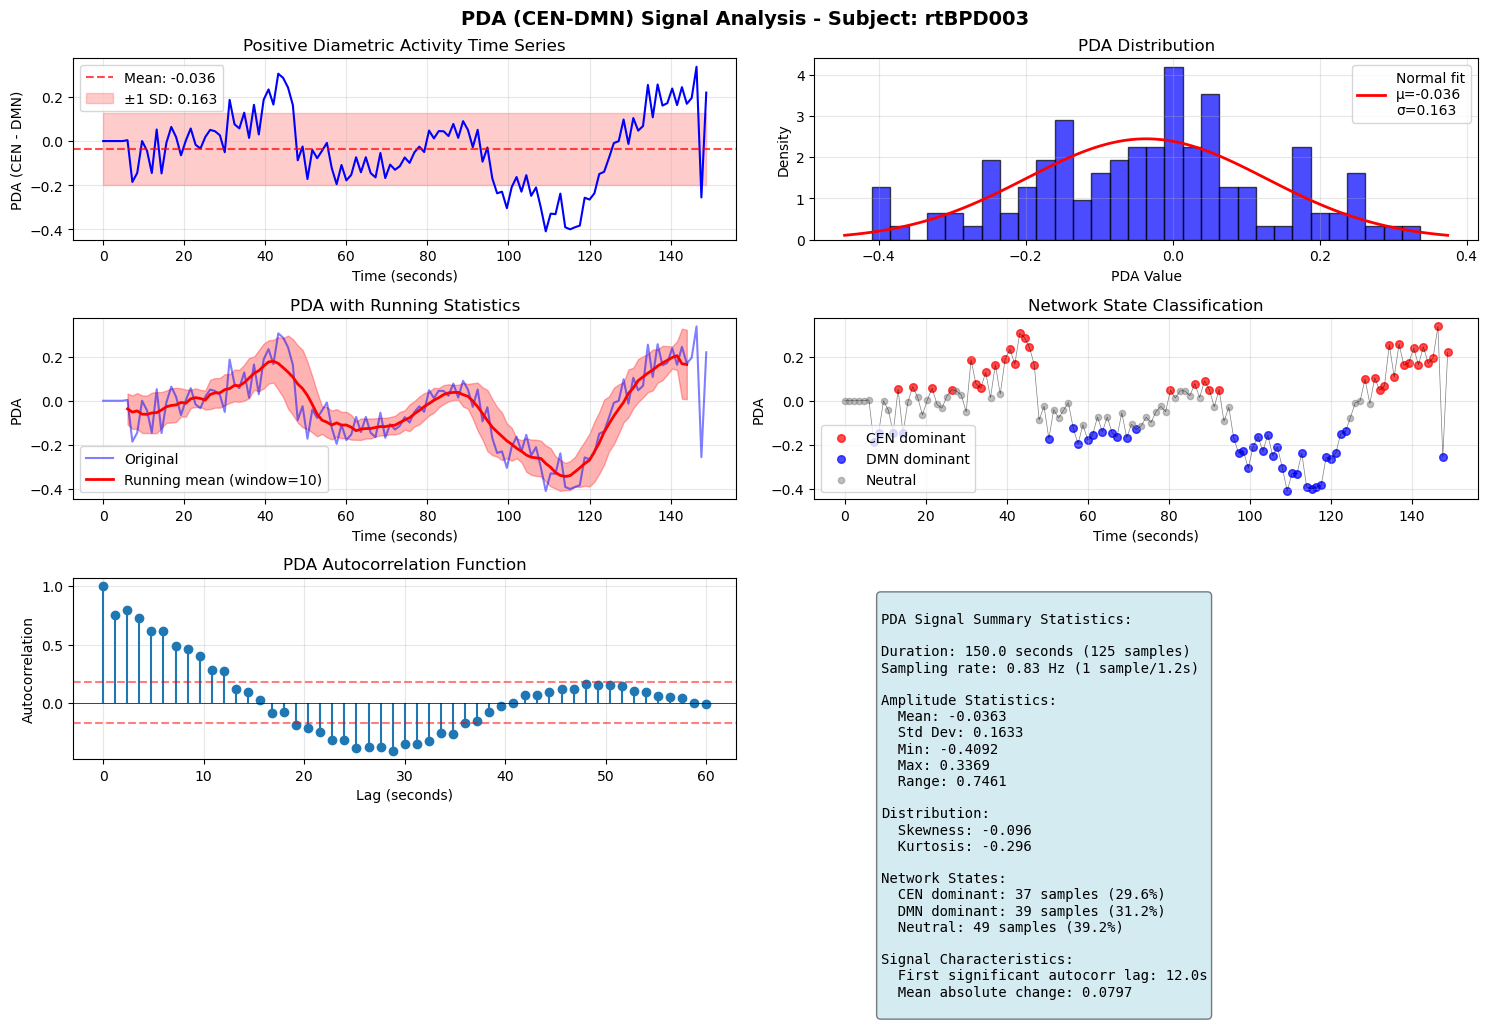


Significant Network Transitions:
--------------------------------------------------
CEN peaks found: 18 at times: [  9.6  13.2  16.8  21.6  26.4  31.2  37.2  43.2  55.2  64.8  68.4  88.8
 104.4 112.8 128.4 134.4 136.8 146.4] seconds
DMN peaks found: 19 at times: [  7.2  12.   14.4  19.2  24.   30.   36.   38.4  50.4  57.6  67.2  69.6
  99.6 109.2 115.2 129.6 135.6 138.  147.6] seconds

Network transitions detected: 36
  DMN→CEN: 7.2s → 9.6s (duration: 2.4s)
  CEN→DMN: 9.6s → 12.0s (duration: 2.4s)
  DMN→CEN: 12.0s → 13.2s (duration: 1.2s)
  CEN→DMN: 13.2s → 14.4s (duration: 1.2s)
  DMN→CEN: 14.4s → 16.8s (duration: 2.4s)


In [34]:
# Comprehensive PDA Signal Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import welch, find_peaks


# Set up the figure
fig = plt.figure(figsize=(15, 10))

# 1. Time series plot
ax1 = plt.subplot(3, 2, 1)
time_points = np.arange(len(pda_signal)) * 1.2  # 1.2 seconds per sample
ax1.plot(time_points, pda_signal, 'b-', linewidth=1.5)
ax1.axhline(y=pda_signal.mean(), color='r', linestyle='--', alpha=0.7, 
            label=f'Mean: {pda_signal.mean():.3f}')
ax1.fill_between(time_points, pda_signal.mean() - pda_signal.std(), 
                 pda_signal.mean() + pda_signal.std(), 
                 alpha=0.2, color='red', label=f'±1 SD: {pda_signal.std():.3f}')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('PDA (CEN - DMN)')
ax1.set_title('Positive Diametric Activity Time Series')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Distribution plot
ax2 = plt.subplot(3, 2, 2)
ax2.hist(pda_signal, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
# Fit normal distribution
mu, std = stats.norm.fit(pda_signal)
xmin, xmax = ax2.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax2.plot(x, p, 'r-', linewidth=2, label=f'Normal fit\nμ={mu:.3f}\nσ={std:.3f}')
ax2.set_xlabel('PDA Value')
ax2.set_ylabel('Density')
ax2.set_title('PDA Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Running statistics
ax3 = plt.subplot(3, 2, 3)
window_size = 10  # 10 samples = 12 seconds
running_mean = pd.Series(pda_signal).rolling(window=window_size, center=True).mean()
running_std = pd.Series(pda_signal).rolling(window=window_size, center=True).std()
ax3.plot(time_points, pda_signal, 'b-', alpha=0.5, label='Original')
ax3.plot(time_points, running_mean, 'r-', linewidth=2, label=f'Running mean (window={window_size})')
ax3.fill_between(time_points, running_mean - running_std, running_mean + running_std, 
                 alpha=0.3, color='red')
ax3.set_xlabel('Time (seconds)')
ax3.set_ylabel('PDA')
ax3.set_title('PDA with Running Statistics')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. State transitions
ax4 = plt.subplot(3, 2, 4)
# Define states based on PDA values
high_cen = pda_signal > pda_signal.mean() + 0.5 * pda_signal.std()
high_dmn = pda_signal < pda_signal.mean() - 0.5 * pda_signal.std()
neutral = ~(high_cen | high_dmn)

# Create state array
states = np.zeros_like(pda_signal)
states[high_cen] = 1  # CEN dominant
states[high_dmn] = -1  # DMN dominant
# neutral remains 0

ax4.plot(time_points, pda_signal, 'k-', alpha=0.5, linewidth=0.5)
ax4.scatter(time_points[high_cen], pda_signal[high_cen], c='red', s=30, 
           label='CEN dominant', alpha=0.7)
ax4.scatter(time_points[high_dmn], pda_signal[high_dmn], c='blue', s=30, 
           label='DMN dominant', alpha=0.7)
ax4.scatter(time_points[neutral], pda_signal[neutral], c='gray', s=20, 
           label='Neutral', alpha=0.5)
ax4.set_xlabel('Time (seconds)')
ax4.set_ylabel('PDA')
ax4.set_title('Network State Classification')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Autocorrelation
ax5 = plt.subplot(3, 2, 5)
from statsmodels.tsa.stattools import acf
lags = 50  # 50 lags = 60 seconds
autocorr = acf(pda_signal, nlags=lags)
lag_times = np.arange(lags + 1) * 1.2  # Convert to seconds
ax5.stem(lag_times, autocorr, basefmt=' ')
ax5.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax5.axhline(y=1.96/np.sqrt(len(pda_signal)), color='r', linestyle='--', alpha=0.5)
ax5.axhline(y=-1.96/np.sqrt(len(pda_signal)), color='r', linestyle='--', alpha=0.5)
ax5.set_xlabel('Lag (seconds)')
ax5.set_ylabel('Autocorrelation')
ax5.set_title('PDA Autocorrelation Function')
ax5.grid(True, alpha=0.3)

# 6. Summary statistics and info
ax6 = plt.subplot(3, 2, 6)
ax6.axis('off')

stats_text = f"""
PDA Signal Summary Statistics:

Duration: {len(pda_signal) * 1.2:.1f} seconds ({len(pda_signal)} samples)
Sampling rate: 0.83 Hz (1 sample/1.2s)

Amplitude Statistics:
  Mean: {pda_signal.mean():.4f}
  Std Dev: {pda_signal.std():.4f}
  Min: {pda_signal.min():.4f}
  Max: {pda_signal.max():.4f}
  Range: {pda_signal.max() - pda_signal.min():.4f}
  
Distribution:
  Skewness: {stats.skew(pda_signal):.3f}
  Kurtosis: {stats.kurtosis(pda_signal):.3f}
  
Network States:
  CEN dominant: {np.sum(high_cen)} samples ({np.sum(high_cen)/len(pda_signal)*100:.1f}%)
  DMN dominant: {np.sum(high_dmn)} samples ({np.sum(high_dmn)/len(pda_signal)*100:.1f}%)
  Neutral: {np.sum(neutral)} samples ({np.sum(neutral)/len(pda_signal)*100:.1f}%)

Signal Characteristics:
  First significant autocorr lag: {np.where(np.abs(autocorr[1:]) < 1.96/np.sqrt(len(pda_signal)))[0][0] * 1.2:.1f}s
  Mean absolute change: {np.mean(np.abs(np.diff(pda_signal))):.4f}
"""

ax6.text(0.1, 0.9, stats_text, transform=ax6.transAxes, 
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.suptitle(f'PDA (CEN-DMN) Signal Analysis - Subject: rtBPD003', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Additional analysis: Find significant transitions
print("\nSignificant Network Transitions:")
print("-" * 50)

# Find peaks and troughs
peaks, peak_props = find_peaks(pda_signal, prominence=0.5*pda_signal.std())
troughs, trough_props = find_peaks(-pda_signal, prominence=0.5*pda_signal.std())

print(f"CEN peaks found: {len(peaks)} at times: {peaks * 1.2} seconds")
print(f"DMN peaks found: {len(troughs)} at times: {troughs * 1.2} seconds")

# Calculate transition times
if len(peaks) > 0 and len(troughs) > 0:
    all_events = sorted([(p, 'CEN') for p in peaks] + [(t, 'DMN') for t in troughs])
    transitions = []
    for i in range(len(all_events)-1):
        if all_events[i][1] != all_events[i+1][1]:
            transitions.append((all_events[i][0], all_events[i+1][0], 
                              f"{all_events[i][1]}→{all_events[i+1][1]}"))
    
    print(f"\nNetwork transitions detected: {len(transitions)}")
    for t1, t2, trans_type in transitions[:5]:  # Show first 5
        print(f"  {trans_type}: {t1*1.2:.1f}s → {t2*1.2:.1f}s (duration: {(t2-t1)*1.2:.1f}s)")

## Step 1: PDA-EEG Alignment with HRF consideration

Using processed EEG data:
EEG duration: 150.0 seconds
EEG sampling rate: 250.0 Hz
Number of channels after cleaning: 29


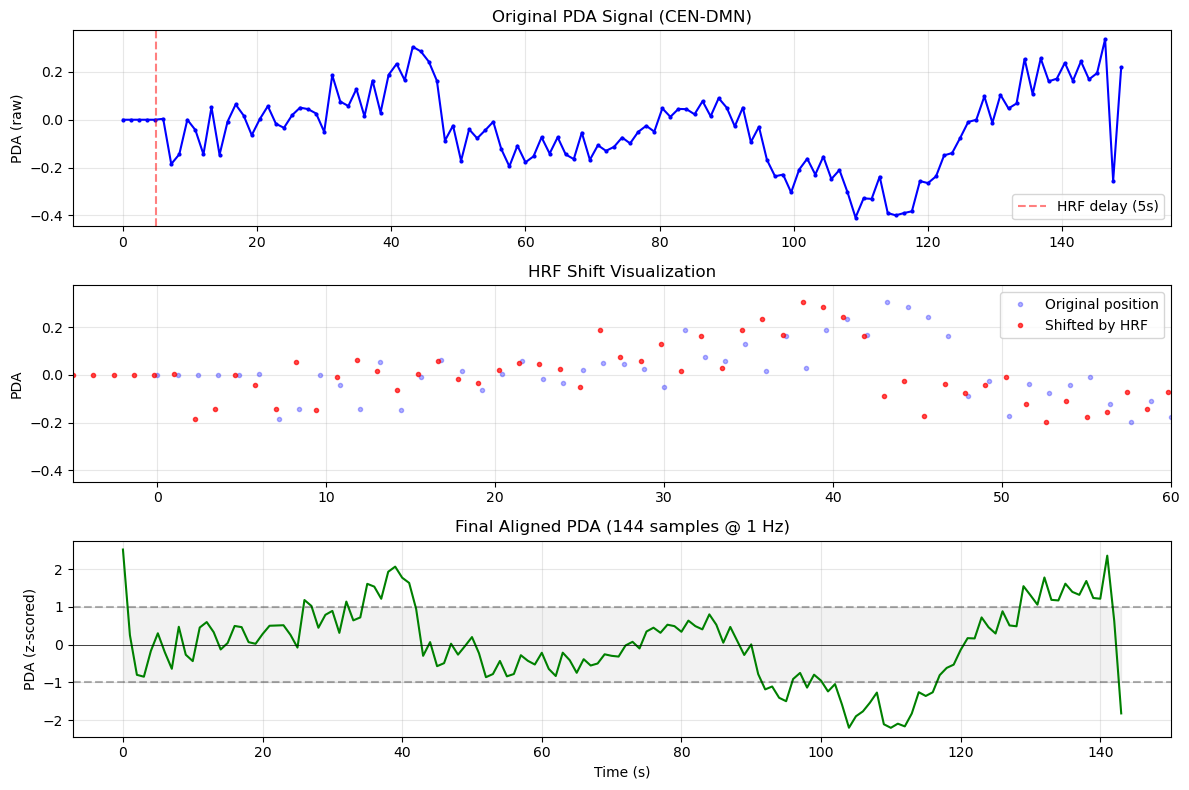


PDA-EEG Alignment Complete!
Original PDA: 125 samples over 150.0s
Aligned PDA: 144 samples over 144.0s
HRF delay applied: 5.0 seconds
Ready for EEG feature extraction!


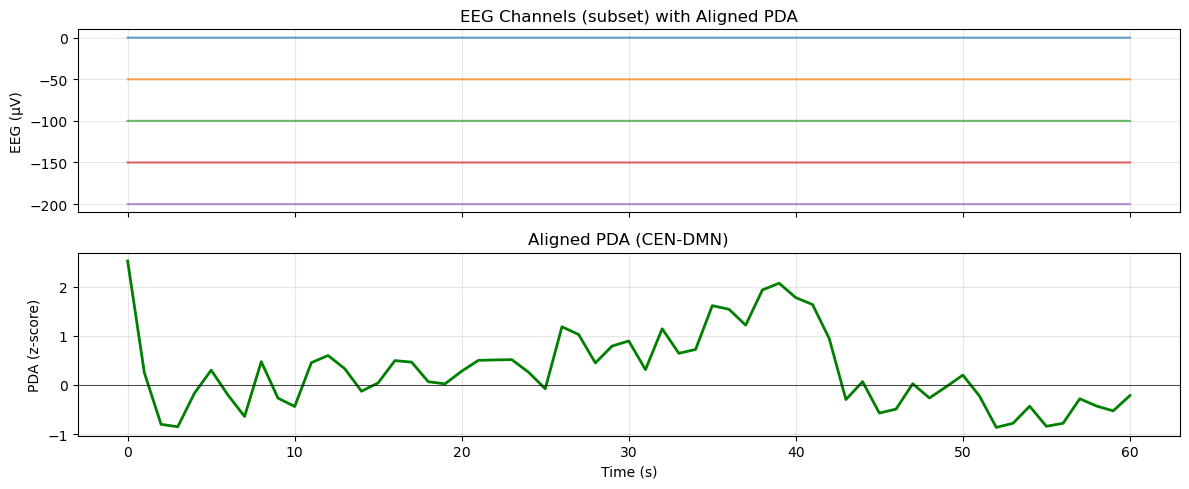

In [35]:
# Use the already processed EEG data
# Assuming raw_processed is already loaded from process_eeg_file()

import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Check what we have
print("Using processed EEG data:")
print(f"EEG duration: {raw_processed.times[-1]:.1f} seconds")
print(f"EEG sampling rate: {raw_processed.info['sfreq']} Hz")
print(f"Number of channels after cleaning: {len(raw_processed.ch_names)}")

# Simple PDA alignment function
def align_pda_to_eeg(pda_signal, raw_data, hrf_delay=5.0, target_fs=1.0):
    """
    Align PDA signal to EEG timeline with HRF delay compensation.
    
    Parameters:
    -----------
    pda_signal : array
        Original PDA signal (1 sample per 1.2 seconds)
    raw_data : mne.io.Raw
        Processed EEG data
    hrf_delay : float
        Hemodynamic response delay in seconds
    target_fs : float
        Target sampling rate for aligned PDA
    
    Returns:
    --------
    pda_aligned_z : array
        Z-scored aligned PDA signal
    pda_time_aligned : array
        Time points for aligned signal
    """
    
    # Original PDA timing
    pda_fs = 1 / 1.2  # ~0.833 Hz
    pda_time_orig = np.arange(len(pda_signal)) * 1.2
    
    # Apply HRF shift (shift backwards in time)
    pda_time_shifted = pda_time_orig - hrf_delay
    
    # Target time points
    eeg_duration = raw_data.times[-1]
    target_time = np.arange(0, min(eeg_duration, pda_time_shifted[-1]), 1/target_fs)
    
    # Only use valid PDA samples (after shift, still positive time)
    valid_idx = pda_time_shifted >= 0
    
    # Interpolate
    interp_func = interp1d(
        pda_time_shifted[valid_idx], 
        pda_signal[valid_idx], 
        kind='cubic',
        bounds_error=False,
        fill_value='extrapolate'
    )
    pda_resampled = interp_func(target_time)
    
    # Z-score normalization
    pda_resampled_z = (pda_resampled - np.mean(pda_resampled)) / np.std(pda_resampled)
    
    return pda_resampled_z, target_time

# Apply alignment using the processed EEG data
pda_aligned_z, pda_time_aligned = align_pda_to_eeg(
    pda_signal, 
    raw_processed,  # Use the cleaned EEG data
    hrf_delay=5.0, 
    target_fs=1.0
)

# Visualize the alignment
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# 1. Original PDA
pda_time_orig = np.arange(len(pda_signal)) * 1.2
axes[0].plot(pda_time_orig, pda_signal, 'b.-', markersize=4)
axes[0].set_ylabel('PDA (raw)')
axes[0].set_title('Original PDA Signal (CEN-DMN)')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=5.0, color='r', linestyle='--', alpha=0.5, label='HRF delay (5s)')
axes[0].legend()

# 2. Show the shift effect
axes[1].plot(pda_time_orig, pda_signal, 'b.', alpha=0.3, label='Original position')
axes[1].plot(pda_time_orig - 5.0, pda_signal, 'r.', alpha=0.7, label='Shifted by HRF')
axes[1].set_ylabel('PDA')
axes[1].set_title('HRF Shift Visualization')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(-5, 60)

# 3. Aligned and normalized PDA
axes[2].plot(pda_time_aligned, pda_aligned_z, 'g-', linewidth=1.5)
axes[2].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[2].axhline(y=1, color='k', linestyle='--', alpha=0.3)
axes[2].axhline(y=-1, color='k', linestyle='--', alpha=0.3)
axes[2].fill_between(pda_time_aligned, -1, 1, alpha=0.1, color='gray')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('PDA (z-scored)')
axes[2].set_title(f'Final Aligned PDA ({len(pda_aligned_z)} samples @ 1 Hz)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print(f"\nPDA-EEG Alignment Complete!")
print(f"Original PDA: {len(pda_signal)} samples over {len(pda_signal)*1.2:.1f}s")
print(f"Aligned PDA: {len(pda_aligned_z)} samples over {len(pda_aligned_z):.1f}s")
print(f"HRF delay applied: 5.0 seconds")
print(f"Ready for EEG feature extraction!")

# Quick check: visualize a portion of EEG with aligned PDA
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

# Plot first 60 seconds
time_limit = 60
eeg_subset = raw_processed.copy().crop(tmin=0, tmax=time_limit)
eeg_data = eeg_subset.get_data()

# Plot a few EEG channels
for i in range(min(5, len(eeg_subset.ch_names))):
    ax1.plot(eeg_subset.times, eeg_data[i] - i*50, alpha=0.7)
ax1.set_ylabel('EEG (μV)')
ax1.set_title('EEG Channels (subset) with Aligned PDA')
ax1.grid(True, alpha=0.3)

# Plot aligned PDA
pda_mask = pda_time_aligned <= time_limit
ax2.plot(pda_time_aligned[pda_mask], pda_aligned_z[pda_mask], 'g-', linewidth=2)
ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('PDA (z-score)')
ax2.set_title('Aligned PDA (CEN-DMN)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 2: STFT Feature Extraction and PDA Alignment


Cleaned EEG data shape: (29, 37500)
Number of good EEG channels: 29
Sampling frequency: 250.0 Hz
STFT window: 1.0 seconds (250 samples)
STFT overlap: 0.5 seconds (125 samples)
STFT output rate: 2.0 Hz

STFT output shape: (29, 126, 301)
Power matrix shape: (301, 29, 126)
Time bins: 301 (from 0.00 to 150.00 seconds)
Frequency bins: 126 (from 0.00 to 125.00 Hz)

Aligned features shape:
  theta: (144, 29)
  alpha: (144, 29)
  beta: (144, 29)
  low_gamma: (144, 29)
  theta_alpha_ratio: (144, 29)
  beta_alpha_ratio: (144, 29)


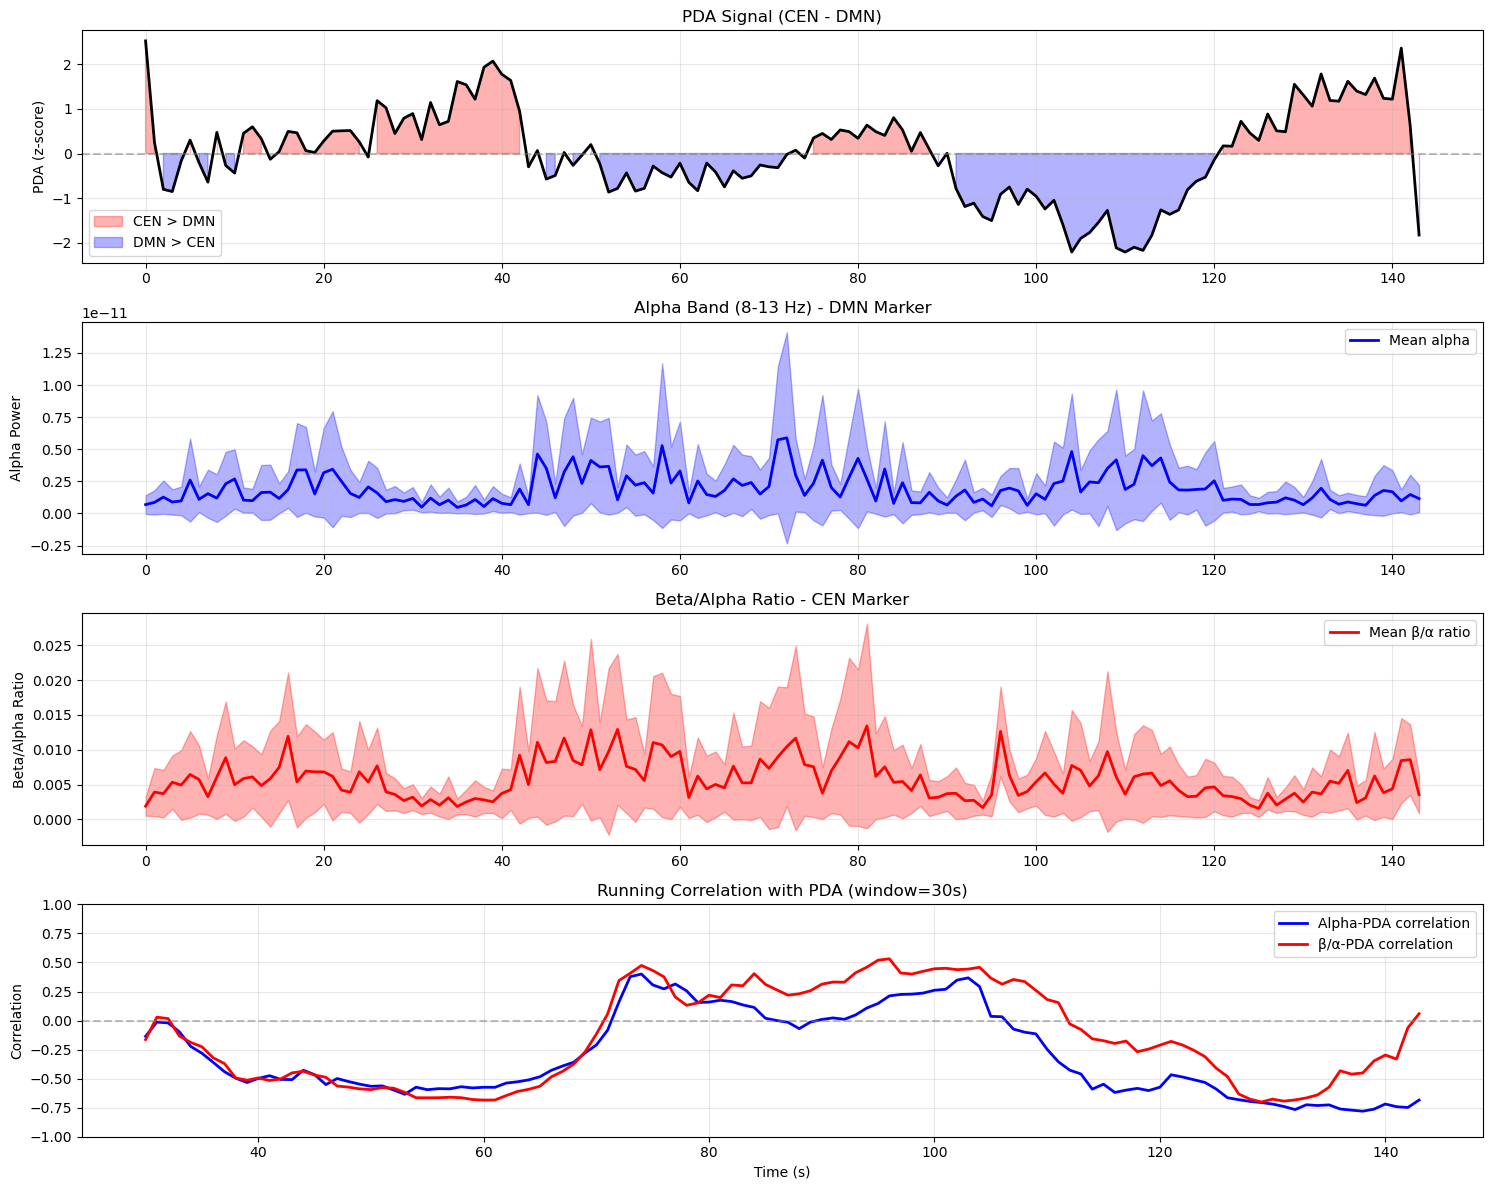


Preparing features for PDA prediction model...

Feature matrix shape: (144, 12)
Target (PDA) shape: (144,)
Features: ['theta_mean', 'theta_std', 'alpha_mean', 'alpha_std', 'beta_mean', 'beta_std', 'low_gamma_mean', 'low_gamma_std', 'theta_alpha_ratio_mean', 'theta_alpha_ratio_std', 'beta_alpha_ratio_mean', 'beta_alpha_ratio_std']

STFT features aligned with PDA and ready for modeling!


In [36]:
import mne
import numpy as np
from scipy.signal import stft
import matplotlib.pyplot as plt

# STFT Parameters optimized for PDA prediction
fs = raw_processed.info['sfreq']  # Using raw_processed instead of raw_clean

# Key insight: We want STFT windows that align with our 1 Hz PDA sampling
# So we'll use 1-second windows with 0.5s overlap (2 Hz output)
window_sec = 1.0  # 1-second window matches PDA timescale
nperseg = int(window_sec * fs)  
noverlap = int(0.5 * fs)  # 50% overlap → 2 Hz output (can downsample to 1 Hz later)

# Extract cleaned EEG data
picks_eeg = mne.pick_types(raw_processed.info, eeg=True)
eeg_data = raw_processed.get_data(picks=picks_eeg)

print(f"Cleaned EEG data shape: {eeg_data.shape}")
print(f"Number of good EEG channels: {len(picks_eeg)}")
print(f"Sampling frequency: {fs} Hz")
print(f"STFT window: {window_sec} seconds ({nperseg} samples)")
print(f"STFT overlap: {noverlap/fs:.1f} seconds ({noverlap} samples)")
print(f"STFT output rate: {fs/(nperseg-noverlap):.1f} Hz")

# Compute STFT across all channels
f, t_stft, Zxx = stft(eeg_data, fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1)

# Calculate power
power = np.abs(Zxx) ** 2
power = power.transpose(2, 0, 1)  # reshape to (n_windows, n_channels, n_freqs)

print(f"\nSTFT output shape: {Zxx.shape}")
print(f"Power matrix shape: {power.shape}")
print(f"Time bins: {len(t_stft)} (from {t_stft[0]:.2f} to {t_stft[-1]:.2f} seconds)")
print(f"Frequency bins: {len(f)} (from {f[0]:.2f} to {f[-1]:.2f} Hz)")

# Extract band powers relevant for CEN-DMN networks
def extract_band_powers(power, freqs, bands=None):
    """
    Extract power in specific frequency bands relevant for network analysis.
    
    Default bands are chosen based on literature on CEN-DMN dynamics:
    - Alpha (8-13 Hz): Default mode network marker
    - Beta (13-30 Hz): Executive network activity
    - Theta (4-8 Hz): Attention and cognitive control
    - Gamma (30-50 Hz): High-level cognitive processing
    """
    
    if bands is None:
        bands = {
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'low_gamma': (30, 50),
            'theta_alpha_ratio': None,  # Will compute separately
            'beta_alpha_ratio': None    # Will compute separately
        }
    
    n_windows, n_channels, _ = power.shape
    band_powers = {}
    
    # Extract absolute band powers
    for band_name, freq_range in bands.items():
        if freq_range is not None:
            low, high = freq_range
            band_mask = (freqs >= low) & (freqs <= high)
            band_powers[band_name] = np.mean(power[:, :, band_mask], axis=2)
    
    # Compute ratio features (important for network states)
    # Theta/Alpha ratio: Higher during focused attention (CEN)
    band_powers['theta_alpha_ratio'] = band_powers['theta'] / (band_powers['alpha'] + 1e-10)
    
    # Beta/Alpha ratio: Higher during executive control (CEN)
    band_powers['beta_alpha_ratio'] = band_powers['beta'] / (band_powers['alpha'] + 1e-10)
    
    return band_powers

# Extract band powers
band_powers = extract_band_powers(power, f)

# Align STFT features with PDA samples
def align_stft_with_pda(t_stft, band_powers, pda_time_aligned):
    """
    Align STFT-derived features with PDA time points.
    """
    from scipy.interpolate import interp1d
    
    aligned_features = {}
    
    for band_name, band_data in band_powers.items():
        # band_data shape: (n_windows, n_channels)
        n_channels = band_data.shape[1]
        
        # Interpolate each channel to PDA time points
        aligned_band = np.zeros((len(pda_time_aligned), n_channels))
        
        for ch in range(n_channels):
            # Create interpolation function
            interp_func = interp1d(t_stft, band_data[:, ch], 
                                 kind='linear', bounds_error=False, 
                                 fill_value='extrapolate')
            # Interpolate to PDA time points
            aligned_band[:, ch] = interp_func(pda_time_aligned)
        
        aligned_features[band_name] = aligned_band
    
    return aligned_features

# Align features with PDA
aligned_band_powers = align_stft_with_pda(t_stft, band_powers, pda_time_aligned)

print(f"\nAligned features shape:")
for band_name, features in aligned_band_powers.items():
    print(f"  {band_name}: {features.shape}")

# Visualization specifically for PDA prediction
def plot_pda_stft_alignment(aligned_band_powers, pda_aligned_z, pda_time_aligned, 
                           channel_names, max_time=300):
    """
    Visualize STFT features aligned with PDA signal.
    """
    fig = plt.figure(figsize=(15, 12))
    
    # Select time range
    time_mask = pda_time_aligned <= max_time
    
    # 1. PDA signal
    ax1 = plt.subplot(4, 1, 1)
    ax1.plot(pda_time_aligned[time_mask], pda_aligned_z[time_mask], 'k-', linewidth=2)
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax1.fill_between(pda_time_aligned[time_mask], 
                     pda_aligned_z[time_mask], 0, 
                     where=pda_aligned_z[time_mask] > 0, 
                     alpha=0.3, color='red', label='CEN > DMN')
    ax1.fill_between(pda_time_aligned[time_mask], 
                     pda_aligned_z[time_mask], 0, 
                     where=pda_aligned_z[time_mask] < 0, 
                     alpha=0.3, color='blue', label='DMN > CEN')
    ax1.set_ylabel('PDA (z-score)')
    ax1.set_title('PDA Signal (CEN - DMN)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Alpha power (DMN marker)
    ax2 = plt.subplot(4, 1, 2)
    alpha_mean = np.mean(aligned_band_powers['alpha'][time_mask], axis=1)
    alpha_std = np.std(aligned_band_powers['alpha'][time_mask], axis=1)
    ax2.plot(pda_time_aligned[time_mask], alpha_mean, 'b-', linewidth=2, label='Mean alpha')
    ax2.fill_between(pda_time_aligned[time_mask], 
                     alpha_mean - alpha_std, 
                     alpha_mean + alpha_std, 
                     alpha=0.3, color='blue')
    ax2.set_ylabel('Alpha Power')
    ax2.set_title('Alpha Band (8-13 Hz) - DMN Marker')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # 3. Beta/Alpha ratio (CEN marker)
    ax3 = plt.subplot(4, 1, 3)
    ratio_mean = np.mean(aligned_band_powers['beta_alpha_ratio'][time_mask], axis=1)
    ratio_std = np.std(aligned_band_powers['beta_alpha_ratio'][time_mask], axis=1)
    ax3.plot(pda_time_aligned[time_mask], ratio_mean, 'r-', linewidth=2, label='Mean β/α ratio')
    ax3.fill_between(pda_time_aligned[time_mask], 
                     ratio_mean - ratio_std, 
                     ratio_mean + ratio_std, 
                     alpha=0.3, color='red')
    ax3.set_ylabel('Beta/Alpha Ratio')
    ax3.set_title('Beta/Alpha Ratio - CEN Marker')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # 4. Correlation between features and PDA
    ax4 = plt.subplot(4, 1, 4)
    
    # Calculate running correlation
    window_size = 30  # 30 seconds
    correlations = {'alpha': [], 'beta_alpha_ratio': []}
    corr_times = []
    
    for i in range(window_size, len(pda_time_aligned[time_mask])):
        window_slice = slice(i-window_size, i)
        
        # Correlation with alpha
        alpha_window = np.mean(aligned_band_powers['alpha'][time_mask][window_slice], axis=1)
        pda_window = pda_aligned_z[time_mask][window_slice]
        correlations['alpha'].append(np.corrcoef(alpha_window, pda_window)[0, 1])
        
        # Correlation with beta/alpha ratio
        ratio_window = np.mean(aligned_band_powers['beta_alpha_ratio'][time_mask][window_slice], axis=1)
        correlations['beta_alpha_ratio'].append(np.corrcoef(ratio_window, pda_window)[0, 1])
        
        corr_times.append(pda_time_aligned[time_mask][i])
    
    ax4.plot(corr_times, correlations['alpha'], 'b-', linewidth=2, label='Alpha-PDA correlation')
    ax4.plot(corr_times, correlations['beta_alpha_ratio'], 'r-', linewidth=2, label='β/α-PDA correlation')
    ax4.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Correlation')
    ax4.set_title(f'Running Correlation with PDA (window={window_size}s)')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    ax4.set_ylim(-1, 1)
    
    plt.tight_layout()
    return fig

# Create visualization
fig = plot_pda_stft_alignment(aligned_band_powers, pda_aligned_z, pda_time_aligned, 
                             [raw_processed.ch_names[i] for i in picks_eeg])
plt.show()

# Prepare features for modeling
print("\nPreparing features for PDA prediction model...")

# Create feature matrix
feature_names = []
features_list = []

for band_name, band_data in aligned_band_powers.items():
    # Add mean and std across channels for each band
    features_list.append(np.mean(band_data, axis=1, keepdims=True))
    feature_names.append(f'{band_name}_mean')
    
    features_list.append(np.std(band_data, axis=1, keepdims=True))
    feature_names.append(f'{band_name}_std')

# Concatenate all features
X_features = np.hstack(features_list)
y_target = pda_aligned_z

print(f"\nFeature matrix shape: {X_features.shape}")
print(f"Target (PDA) shape: {y_target.shape}")
print(f"Features: {feature_names}")

# Save aligned data for modeling
stft_pda_data = {
    'X_features': X_features,
    'y_target': y_target,
    'feature_names': feature_names,
    'time_points': pda_time_aligned,
    'aligned_band_powers': aligned_band_powers,
    'channel_names': [raw_processed.ch_names[i] for i in picks_eeg]
}

print("\nSTFT features aligned with PDA and ready for modeling!")

## Step 4: Adaptive Frequency Bands for Network State Prediction

Step 4.1: Compute total energy per frequency bin

Creating frequency bands...


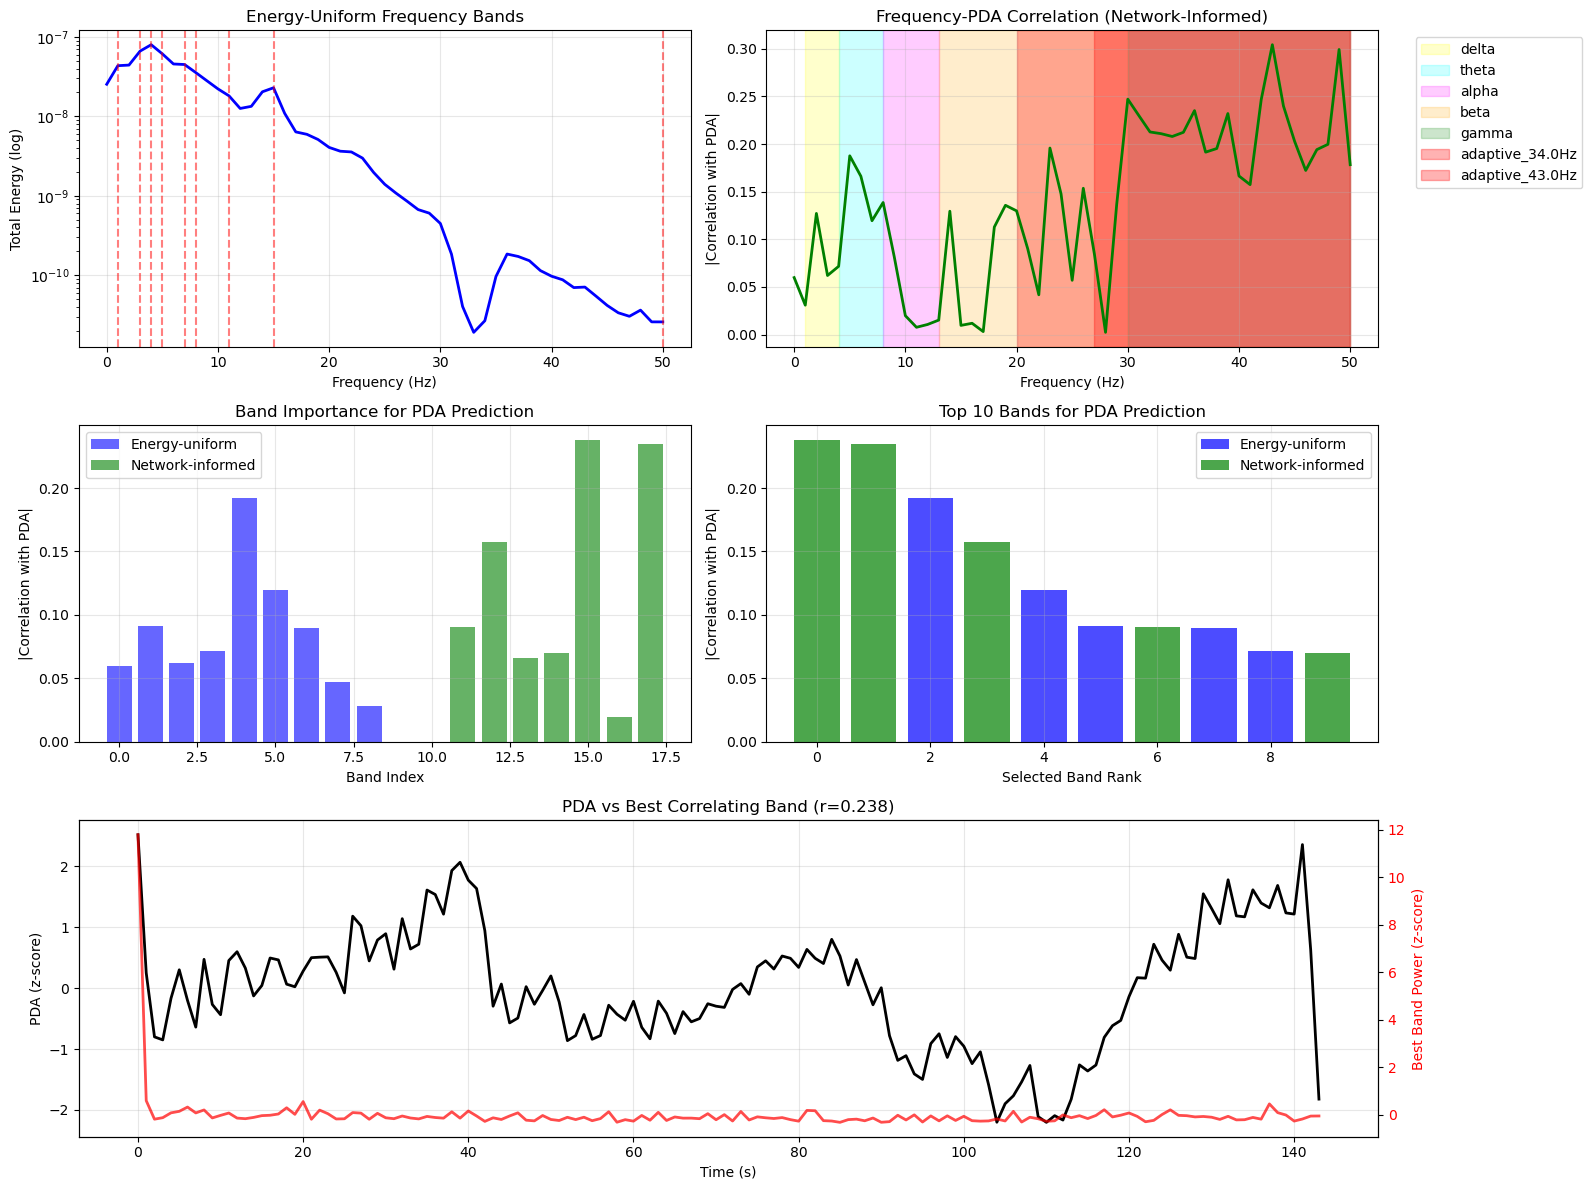


=== Feature Selection Summary ===
Energy-uniform bands: 10 bands
Network-informed bands: 7 bands

Top 5 bands for PDA prediction:
1. gamma: r=0.238
2. adaptive_43.0Hz: r=0.235
3. energy_band_4: r=0.192
4. theta: r=0.157
5. energy_band_5: r=0.120

Features ready for modeling!


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Two approaches: Energy-based AND Network-informed bands

## Approach 1: Energy-Uniform Bands (your current approach, cleaned up)
def create_energy_uniform_bands(power, freqs, n_bands=10, max_freq=50):
    """
    Create frequency bands with equal energy distribution.
    """
    n_windows, n_channels, n_freqs = power.shape
    
    # Limit to relevant frequencies
    freq_mask = freqs <= max_freq
    freqs_limited = freqs[freq_mask]
    power_limited = power[:, :, freq_mask]
    
    # Sum across time and channels to get total energy per freq bin
    total_energy_per_freq = power_limited.sum(axis=(0, 1))
    
    # Compute cumulative energy
    cumulative_energy = np.cumsum(total_energy_per_freq)
    total_energy = cumulative_energy[-1]
    
    # Create equally spaced energy points
    energy_bins = np.linspace(0, total_energy, n_bands + 1)
    
    # Find frequency indices that split energy equally
    band_edges = np.searchsorted(cumulative_energy, energy_bins)
    band_edges = np.unique(band_edges)
    
    # Ensure we have the right number of edges
    if len(band_edges) < n_bands + 1:
        band_edges = np.pad(band_edges, (0, n_bands + 1 - len(band_edges)), 
                           mode='constant', constant_values=len(freqs_limited)-1)
    band_edges = band_edges[:n_bands + 1]
    band_edges[-1] = len(freqs_limited) - 1
    
    return band_edges, freqs_limited, power_limited

## Approach 2: Network-Informed Adaptive Bands
def create_network_informed_bands(power, freqs, pda_signal, max_freq=50):
    """
    Create frequency bands based on correlation with PDA signal.
    This finds frequency ranges that are most informative for CEN-DMN dynamics.
    """
    n_windows, n_channels, n_freqs = power.shape
    
    # Limit to relevant frequencies
    freq_mask = freqs <= max_freq
    freqs_limited = freqs[freq_mask]
    power_limited = power[:, :, freq_mask]
    
    # Ensure PDA is aligned with power windows
    if len(pda_signal) > n_windows:
        pda_aligned = pda_signal[:n_windows]
    else:
        pda_aligned = pda_signal
    
    # Calculate correlation between each frequency and PDA
    freq_correlations = np.zeros(power_limited.shape[2])
    
    for f_idx in range(power_limited.shape[2]):
        # Average power across channels for this frequency
        freq_power = np.mean(power_limited[:len(pda_aligned), :, f_idx], axis=1)
        
        # Correlate with PDA
        if np.std(freq_power) > 0:
            corr, _ = pearsonr(freq_power, pda_aligned)
            freq_correlations[f_idx] = abs(corr)  # Use absolute correlation
    
    # Smooth correlations to find regions
    from scipy.ndimage import gaussian_filter1d
    freq_correlations_smooth = gaussian_filter1d(freq_correlations, sigma=2)
    
    # Find peaks in correlation
    from scipy.signal import find_peaks
    peaks, properties = find_peaks(freq_correlations_smooth, 
                                  height=np.mean(freq_correlations_smooth),
                                  distance=5)
    
    # Define adaptive bands around correlation peaks
    adaptive_bands = []
    
    # Always include standard neuroscience bands
    standard_bands = [
        (1, 4, 'delta'),
        (4, 8, 'theta'),
        (8, 13, 'alpha'),
        (13, 30, 'beta'),
        (30, 50, 'gamma')
    ]
    
    # Add high-correlation regions as additional bands
    for peak in peaks:
        peak_freq = freqs_limited[peak]
        
        # Find band edges (where correlation drops)
        left_edge = peak
        while left_edge > 0 and freq_correlations_smooth[left_edge] > freq_correlations_smooth[peak] * 0.5:
            left_edge -= 1
        
        right_edge = peak
        while right_edge < len(freq_correlations_smooth) - 1 and \
              freq_correlations_smooth[right_edge] > freq_correlations_smooth[peak] * 0.5:
            right_edge += 1
        
        adaptive_bands.append((freqs_limited[left_edge], freqs_limited[right_edge], f'adaptive_{peak_freq:.1f}Hz'))
    
    return standard_bands, adaptive_bands, freq_correlations, freqs_limited

# Apply both approaches
print("Creating frequency bands...")

# Energy-uniform bands
energy_edges, freqs_limited, power_limited = create_energy_uniform_bands(power, f, n_bands=10)

# Network-informed bands
standard_bands, adaptive_bands, freq_correlations, _ = create_network_informed_bands(
    power, f, pda_aligned_z)

# Visualization comparing approaches
fig = plt.figure(figsize=(16, 12))

# 1. Energy distribution with energy-uniform bands
ax1 = plt.subplot(3, 2, 1)
total_energy = power_limited.sum(axis=(0, 1))
ax1.semilogy(freqs_limited, total_energy, 'b-', linewidth=2)
for edge in energy_edges[1:-1]:
    ax1.axvline(x=freqs_limited[edge], color='red', linestyle='--', alpha=0.5)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Total Energy (log)')
ax1.set_title('Energy-Uniform Frequency Bands')
ax1.grid(True, alpha=0.3)

# 2. Frequency-PDA correlation
ax2 = plt.subplot(3, 2, 2)
ax2.plot(freqs_limited[:len(freq_correlations)], freq_correlations, 'g-', linewidth=2)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('|Correlation with PDA|')
ax2.set_title('Frequency-PDA Correlation (Network-Informed)')

# Mark standard bands
colors = ['yellow', 'cyan', 'magenta', 'orange', 'green']
for (low, high, name), color in zip(standard_bands, colors):
    ax2.axvspan(low, high, alpha=0.2, color=color, label=name)

# Mark adaptive bands
for low, high, name in adaptive_bands:
    ax2.axvspan(low, high, alpha=0.3, color='red', label=name if 'adaptive' in name else '')

ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# 3. Extract features using both approaches
def extract_band_features(power, freqs, bands, is_edge_based=False):
    """Extract band power features."""
    n_windows, n_channels, n_freqs = power.shape
    
    if is_edge_based:
        # For energy-uniform bands (edge-based)
        n_bands = len(bands) - 1
        features = np.zeros((n_windows, n_channels, n_bands))
        
        for i in range(n_bands):
            start_idx = bands[i]
            end_idx = bands[i + 1]
            if end_idx > start_idx:
                features[:, :, i] = power[:, :, start_idx:end_idx].mean(axis=2)
    else:
        # For frequency range bands
        n_bands = len(bands)
        features = np.zeros((n_windows, n_channels, n_bands))
        
        for i, (low, high, name) in enumerate(bands):
            band_mask = (freqs >= low) & (freqs <= high)
            if np.any(band_mask):
                features[:, :, i] = power[:, :, band_mask].mean(axis=2)
    
    return features

# Extract features
energy_features = extract_band_features(power_limited, freqs_limited, energy_edges, is_edge_based=True)
network_features = extract_band_features(power, f, standard_bands + adaptive_bands, is_edge_based=False)

# 4. Compare feature importance for PDA prediction
ax3 = plt.subplot(3, 2, 3)

# Calculate correlation of each band with PDA
energy_band_corrs = []
for i in range(energy_features.shape[2]):
    band_power = np.mean(energy_features[:len(pda_aligned_z), :, i], axis=1)
    if np.std(band_power) > 0:
        corr, _ = pearsonr(band_power, pda_aligned_z[:len(band_power)])
        energy_band_corrs.append(abs(corr))
    else:
        energy_band_corrs.append(0)

network_band_corrs = []
band_names = [name for _, _, name in standard_bands + adaptive_bands]
for i in range(network_features.shape[2]):
    band_power = np.mean(network_features[:len(pda_aligned_z), :, i], axis=1)
    if np.std(band_power) > 0:
        corr, _ = pearsonr(band_power, pda_aligned_z[:len(band_power)])
        network_band_corrs.append(abs(corr))
    else:
        network_band_corrs.append(0)

# Bar plot comparison
x1 = np.arange(len(energy_band_corrs))
x2 = np.arange(len(network_band_corrs)) + len(energy_band_corrs) + 1

bars1 = ax3.bar(x1, energy_band_corrs, color='blue', alpha=0.6, label='Energy-uniform')
bars2 = ax3.bar(x2, network_band_corrs, color='green', alpha=0.6, label='Network-informed')

# Highlight top correlations
for bars in [bars1, bars2]:
    for bar in bars:
        if bar.get_height() > 0.3:
            bar.set_color('red')
            bar.set_alpha(0.8)

ax3.set_xlabel('Band Index')
ax3.set_ylabel('|Correlation with PDA|')
ax3.set_title('Band Importance for PDA Prediction')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 5. Optimal band selection
ax4 = plt.subplot(3, 2, 4)

# Combine both approaches - select top bands
all_correlations = [(i, corr, 'energy') for i, corr in enumerate(energy_band_corrs)] + \
                  [(i, corr, 'network') for i, corr in enumerate(network_band_corrs)]

# Sort by correlation
all_correlations.sort(key=lambda x: x[1], reverse=True)

# Select top 10 bands
top_bands = all_correlations[:10]

# Visualize selected bands
band_types = [b[2] for b in top_bands]
band_corrs = [b[1] for b in top_bands]
colors = ['blue' if t == 'energy' else 'green' for t in band_types]

bars = ax4.bar(range(len(top_bands)), band_corrs, color=colors, alpha=0.7)
ax4.set_xlabel('Selected Band Rank')
ax4.set_ylabel('|Correlation with PDA|')
ax4.set_title('Top 10 Bands for PDA Prediction')
ax4.grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', alpha=0.7, label='Energy-uniform'),
                  Patch(facecolor='green', alpha=0.7, label='Network-informed')]
ax4.legend(handles=legend_elements)

# 6. Time series comparison
ax5 = plt.subplot(3, 1, 3)

# Plot PDA
time_limit = min(300, len(pda_aligned_z))
time_axis = pda_time_aligned[:time_limit]

ax5_twin = ax5.twinx()
ax5.plot(time_axis, pda_aligned_z[:time_limit], 'k-', linewidth=2, label='PDA')
ax5.set_ylabel('PDA (z-score)', color='k')
ax5.tick_params(axis='y', labelcolor='k')

# Plot best correlating band
best_band_idx = top_bands[0][0]
best_band_type = top_bands[0][2]

if best_band_type == 'energy':
    best_band_power = np.mean(energy_features[:time_limit, :, best_band_idx], axis=1)
else:
    best_band_power = np.mean(network_features[:time_limit, :, best_band_idx], axis=1)

# Normalize for visualization
best_band_power_norm = (best_band_power - np.mean(best_band_power)) / np.std(best_band_power)

ax5_twin.plot(time_axis[:len(best_band_power_norm)], best_band_power_norm, 'r-', 
              linewidth=2, alpha=0.7, label='Best Band')
ax5_twin.set_ylabel('Best Band Power (z-score)', color='r')
ax5_twin.tick_params(axis='y', labelcolor='r')

ax5.set_xlabel('Time (s)')
ax5.set_title(f'PDA vs Best Correlating Band (r={top_bands[0][1]:.3f})')
ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Prepare final feature set
print("\n=== Feature Selection Summary ===")
print(f"Energy-uniform bands: {len(energy_band_corrs)} bands")
print(f"Network-informed bands: {len(network_band_corrs)} bands")
print(f"\nTop 5 bands for PDA prediction:")
for i, (idx, corr, band_type) in enumerate(top_bands[:5]):
    if band_type == 'network' and idx < len(band_names):
        band_name = band_names[idx]
    else:
        band_name = f"{band_type}_band_{idx}"
    print(f"{i+1}. {band_name}: r={corr:.3f}")

# Create optimized feature set
optimized_features = {
    'energy_features': energy_features,
    'network_features': network_features,
    'top_band_indices': [(idx, band_type) for idx, _, band_type in top_bands[:10]],
    'band_correlations': {
        'energy': energy_band_corrs,
        'network': network_band_corrs
    },
    'standard_bands': standard_bands,
    'adaptive_bands': adaptive_bands
}

print("\nFeatures ready for modeling!")

## Advanced EEG Features for PDA Prediciton

Starting advanced feature extraction...
Extracting advanced EEG features...
1. Extracting band powers...
2. Computing ratio features...
3. Extracting spatial features...
  Found 6 frontal, 7 central, 5 parietal channels
4. Computing connectivity features...
5. Computing temporal dynamics...
6. Creating network-specific features...
7. Aligning features with PDA time points...
8. Adding lagged features...

9. Computing feature-PDA correlations...

Top 10 features by correlation with PDA:
------------------------------------------------------------
Feature                             Correlation    p-value
------------------------------------------------------------
alpha_beta_ratio_mean                   -0.372     0.0000
alpha_beta_ratio_std                    -0.353     0.0000
beta_alpha_ratio_mean_lag2              -0.264     0.0014
beta_alpha_ratio_mean_lag1              -0.249     0.0026
theta_beta_ratio_mean                   -0.240     0.0038
theta_alpha_ratio_mean                

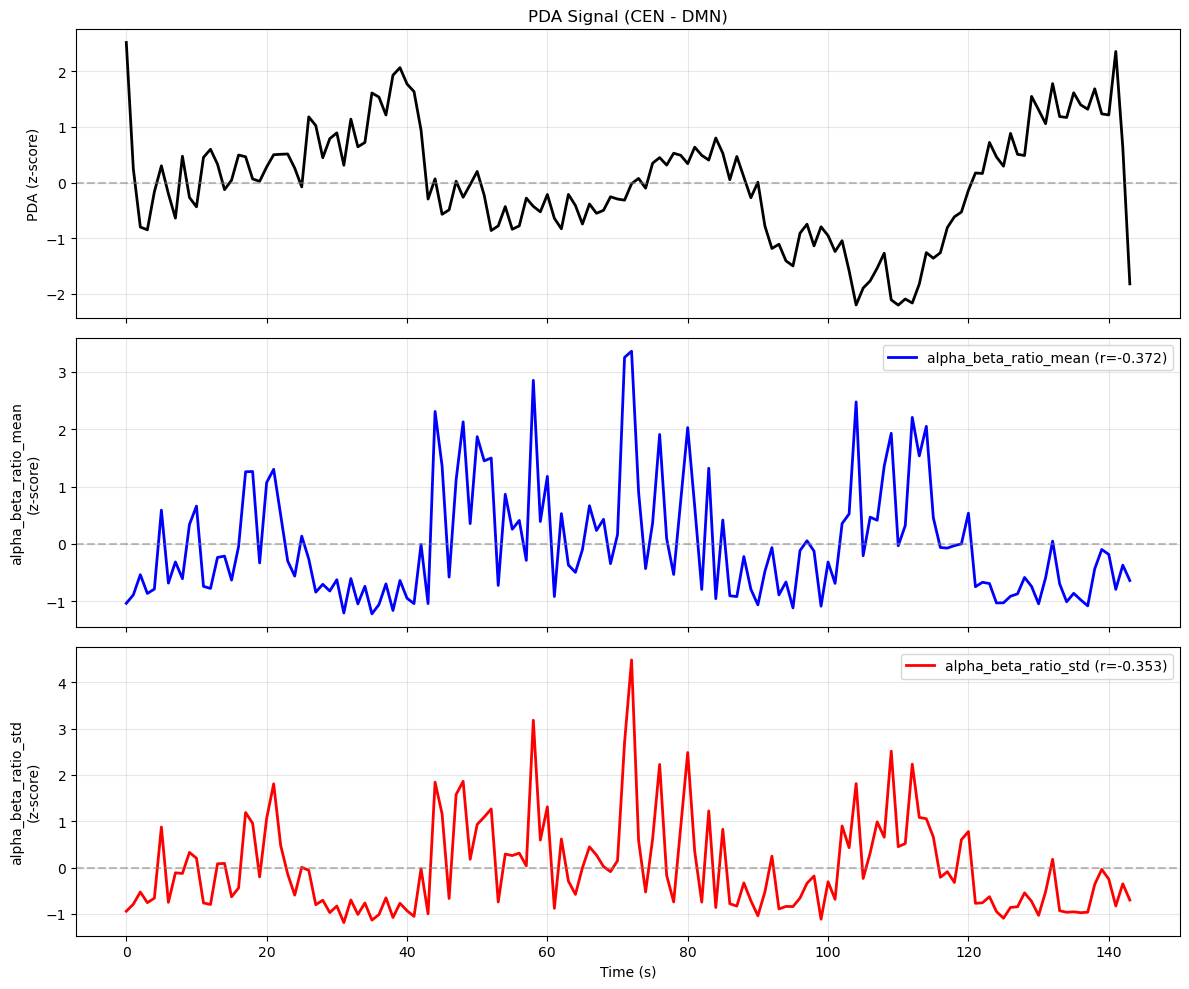


Total features extracted: 32
Feature matrix shape: (144, 32)

Ready for machine learning models!


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import mne

def extract_advanced_eeg_features(power, freqs, stft_times, raw_processed, pda_aligned_z, pda_time_aligned):
    """
    Extract advanced EEG features for improved PDA prediction.
    
    Parameters:
    -----------
    power : array, shape (n_windows, n_channels, n_freqs)
        Power spectral density from STFT
    freqs : array
        Frequency bins from STFT
    stft_times : array
        Time points from STFT
    raw_processed : mne.io.Raw
        Processed EEG data
    pda_aligned_z : array
        Aligned and z-scored PDA signal
    pda_time_aligned : array
        Time points for aligned PDA
    """
    
    # Get basic info
    n_windows, n_channels, n_freqs = power.shape
    picks_eeg = mne.pick_types(raw_processed.info, eeg=True)
    channel_names = [raw_processed.ch_names[i] for i in picks_eeg]
    fs = raw_processed.info['sfreq']
    
    # Define frequency bands based on neuroscience literature
    bands = {
        'delta': (1, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'low_beta': (13, 20),
        'high_beta': (20, 30),
        'gamma': (30, 45)
    }
    
    # Initialize feature dictionary
    features = {}
    
    print("Extracting advanced EEG features...")
    
    # 1. BAND POWER FEATURES
    print("1. Extracting band powers...")
    band_powers = {}
    for band_name, (low, high) in bands.items():
        band_mask = (freqs >= low) & (freqs <= high)
        if np.any(band_mask):
            band_powers[band_name] = np.mean(power[:, :, band_mask], axis=2)
        else:
            print(f"Warning: No frequencies found for {band_name} band")
            band_powers[band_name] = np.zeros((n_windows, n_channels))
    
    # 2. RATIO FEATURES (important for network states)
    print("2. Computing ratio features...")
    # Add small epsilon to avoid division by zero
    eps = 1e-10
    features['theta_beta_ratio'] = band_powers['theta'] / (band_powers['low_beta'] + eps)
    features['alpha_beta_ratio'] = band_powers['alpha'] / (band_powers['high_beta'] + eps)
    features['theta_alpha_ratio'] = band_powers['theta'] / (band_powers['alpha'] + eps)
    features['beta_alpha_ratio'] = (band_powers['low_beta'] + band_powers['high_beta']) / (band_powers['alpha'] + eps)
    
    # 3. SPATIAL FEATURES - Focus on regions relevant to CEN/DMN
    print("3. Extracting spatial features...")
    
    # Find frontal, central, and parietal channels
    frontal_channels = []
    central_channels = []
    parietal_channels = []
    
    for i, ch in enumerate(channel_names):
        ch_upper = ch.upper()
        # Frontal
        if any(x in ch_upper for x in ['FP1', 'FP2', 'AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FZ']):
            frontal_channels.append(i)
        # Central
        if any(x in ch_upper for x in ['C3', 'C4', 'CZ', 'FC1', 'FC2', 'CP1', 'CP2']):
            central_channels.append(i)
        # Parietal
        if any(x in ch_upper for x in ['P3', 'P4', 'PZ', 'P7', 'P8', 'PO3', 'PO4']):
            parietal_channels.append(i)
    
    print(f"  Found {len(frontal_channels)} frontal, {len(central_channels)} central, {len(parietal_channels)} parietal channels")
    
    # Frontal-Parietal alpha gradient (DMN marker)
    if frontal_channels and parietal_channels:
        frontal_alpha = np.mean(band_powers['alpha'][:, frontal_channels], axis=1)
        parietal_alpha = np.mean(band_powers['alpha'][:, parietal_channels], axis=1)
        features['frontal_parietal_alpha_gradient'] = parietal_alpha - frontal_alpha
    else:
        print("  Warning: Could not compute frontal-parietal gradient")
        features['frontal_parietal_alpha_gradient'] = np.zeros(n_windows)
    
    # Frontal beta (CEN marker)
    if frontal_channels:
        features['frontal_beta'] = np.mean(band_powers['high_beta'][:, frontal_channels], axis=1)
        features['frontal_theta'] = np.mean(band_powers['theta'][:, frontal_channels], axis=1)
    else:
        features['frontal_beta'] = np.mean(band_powers['high_beta'], axis=1)
        features['frontal_theta'] = np.mean(band_powers['theta'], axis=1)
    
    # 4. CONNECTIVITY FEATURES (simplified)
    print("4. Computing connectivity features...")
    
    # Alpha band connectivity
    alpha_connectivity = []
    for window in range(n_windows):
        # Get alpha band power for this window across channels
        alpha_window = band_powers['alpha'][window, :]
        
        # Compute mean correlation between channels
        if len(alpha_window) > 1 and np.std(alpha_window) > 0:
            # Create correlation matrix
            alpha_reshaped = alpha_window.reshape(-1, 1)
            # Simple connectivity: std across channels (as proxy for desynchronization)
            alpha_connectivity.append(np.std(alpha_window))
        else:
            alpha_connectivity.append(0)
    
    features['alpha_connectivity'] = np.array(alpha_connectivity)
    
    # 5. TEMPORAL DYNAMICS
    print("5. Computing temporal dynamics...")
    
    # Rate of change in alpha power
    alpha_mean = np.mean(band_powers['alpha'], axis=1)
    features['alpha_derivative'] = np.gradient(alpha_mean)
    
    # Variability in beta/alpha ratio
    beta_alpha = np.mean(features['beta_alpha_ratio'], axis=1)
    
    # Compute running std with window of 5
    window_size = 5
    beta_alpha_var = np.zeros_like(beta_alpha)
    for i in range(len(beta_alpha)):
        start = max(0, i - window_size//2)
        end = min(len(beta_alpha), i + window_size//2 + 1)
        beta_alpha_var[i] = np.std(beta_alpha[start:end])
    
    features['beta_alpha_variability'] = beta_alpha_var
    
    # 6. NETWORK-SPECIFIC COMPOSITE FEATURES
    print("6. Creating network-specific features...")
    
    # DMN index: High posterior alpha, low frontal beta
    if parietal_channels and frontal_channels:
        dmn_index = (np.mean(band_powers['alpha'][:, parietal_channels], axis=1) - 
                     np.mean(band_powers['high_beta'][:, frontal_channels], axis=1))
        cen_index = (np.mean(band_powers['high_beta'][:, frontal_channels], axis=1) + 
                     np.mean(band_powers['theta'][:, frontal_channels], axis=1) - 
                     np.mean(band_powers['alpha'][:, parietal_channels], axis=1))
    else:
        # Fallback: use all channels
        dmn_index = np.mean(band_powers['alpha'], axis=1) - np.mean(band_powers['high_beta'], axis=1)
        cen_index = np.mean(band_powers['high_beta'], axis=1) - np.mean(band_powers['alpha'], axis=1)
    
    features['dmn_index'] = dmn_index
    features['cen_index'] = cen_index
    features['network_competition'] = cen_index - dmn_index
    
    # 7. ALIGN ALL FEATURES WITH PDA
    print("7. Aligning features with PDA time points...")
    
    from scipy.interpolate import interp1d
    
    # Ensure we have valid time arrays
    if len(stft_times) != n_windows:
        print(f"  Warning: Time array mismatch. Creating new time array.")
        stft_times = np.linspace(0, raw_processed.times[-1], n_windows)
    
    # Align each feature
    aligned_features = {}
    feature_names = []
    
    for feat_name, feat_data in features.items():
        if isinstance(feat_data, np.ndarray):
            # 1D feature
            if feat_data.ndim == 1 and len(feat_data) == n_windows:
                try:
                    interp_func = interp1d(stft_times, feat_data, kind='linear', 
                                         bounds_error=False, fill_value='extrapolate')
                    aligned_features[feat_name] = interp_func(pda_time_aligned)
                    feature_names.append(feat_name)
                except Exception as e:
                    print(f"  Warning: Could not align {feat_name}: {e}")
            
            # 2D feature (per channel)
            elif feat_data.ndim == 2 and feat_data.shape[0] == n_windows:
                # Take mean across channels
                feat_mean = np.mean(feat_data, axis=1)
                try:
                    interp_func = interp1d(stft_times, feat_mean, kind='linear', 
                                         bounds_error=False, fill_value='extrapolate')
                    aligned_features[feat_name + '_mean'] = interp_func(pda_time_aligned)
                    feature_names.append(feat_name + '_mean')
                    
                    # Also include std across channels
                    feat_std = np.std(feat_data, axis=1)
                    interp_func = interp1d(stft_times, feat_std, kind='linear', 
                                         bounds_error=False, fill_value='extrapolate')
                    aligned_features[feat_name + '_std'] = interp_func(pda_time_aligned)
                    feature_names.append(feat_name + '_std')
                except Exception as e:
                    print(f"  Warning: Could not align {feat_name}: {e}")
    
    # 8. Add lagged features
    print("8. Adding lagged features...")
    
    lag_samples = [1, 2, 3]  # 1-3 seconds additional lag
    key_features = ['network_competition', 'cen_index', 'dmn_index', 
                    'beta_alpha_ratio_mean', 'alpha_connectivity']
    
    for lag in lag_samples:
        for feat in key_features:
            if feat in aligned_features:
                lagged_feat = np.roll(aligned_features[feat], lag)
                lagged_feat[:lag] = lagged_feat[lag]  # Pad beginning
                aligned_features[f'{feat}_lag{lag}'] = lagged_feat
                feature_names.append(f'{feat}_lag{lag}')
    
    # 9. COMPUTE CORRELATIONS
    print("\n9. Computing feature-PDA correlations...")
    
    correlations = {}
    for feat_name, feat_data in aligned_features.items():
        if np.std(feat_data) > 1e-10:
            corr, p_val = pearsonr(feat_data, pda_aligned_z)
            correlations[feat_name] = {'r': corr, 'p': p_val}
    
    # Sort by absolute correlation
    sorted_corrs = sorted(correlations.items(), key=lambda x: abs(x[1]['r']), reverse=True)
    
    print("\nTop 10 features by correlation with PDA:")
    print("-" * 60)
    print(f"{'Feature':<35} {'Correlation':>10} {'p-value':>10}")
    print("-" * 60)
    for feat, stats in sorted_corrs[:10]:
        print(f"{feat:<35} {stats['r']:>10.3f} {stats['p']:>10.4f}")
    
    # Create feature matrix
    feature_matrix = np.column_stack([aligned_features[feat] for feat in feature_names])
    
    # Visualization
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    time_mask = pda_time_aligned <= min(300, pda_time_aligned[-1])
    
    # PDA signal
    axes[0].plot(pda_time_aligned[time_mask], pda_aligned_z[time_mask], 'k-', linewidth=2)
    axes[0].set_ylabel('PDA (z-score)')
    axes[0].set_title('PDA Signal (CEN - DMN)')
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Top 2 features
    if len(sorted_corrs) >= 2:
        colors = ['blue', 'red']
        for i in range(2):
            feat_name, stats = sorted_corrs[i]
            ax = axes[i+1]
            feat_data = aligned_features[feat_name]
            
            # Normalize for visualization
            feat_norm = (feat_data - np.mean(feat_data)) / (np.std(feat_data) + 1e-10)
            
            ax.plot(pda_time_aligned[time_mask], feat_norm[time_mask], 
                    color=colors[i], linewidth=2, label=f"{feat_name} (r={stats['r']:.3f})")
            ax.set_ylabel(f'{feat_name}\n(z-score)')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    axes[-1].set_xlabel('Time (s)')
    plt.tight_layout()
    plt.show()
    
    return {
        'feature_matrix': feature_matrix,
        'feature_names': feature_names,
        'aligned_features': aligned_features,
        'correlations': correlations,
        'sorted_correlations': sorted_corrs,
        'band_powers': band_powers,
        'spatial_info': {
            'frontal_channels': frontal_channels,
            'central_channels': central_channels,
            'parietal_channels': parietal_channels
        }
    }

# Run advanced feature extraction
# Using the STFT results from previous computations
print("Starting advanced feature extraction...")
advanced_features = extract_advanced_eeg_features(
    power,           # From STFT
    f,               # Frequencies from STFT  
    t_stft,          # Time points from STFT
    raw_processed,   # Processed EEG data
    pda_aligned_z,   # Aligned PDA signal
    pda_time_aligned # PDA time points
)

print(f"\nTotal features extracted: {len(advanced_features['feature_names'])}")
print(f"Feature matrix shape: {advanced_features['feature_matrix'].shape}")
print("\nReady for machine learning models!")

# Save the features for modeling
np.savez('eeg_pda_features.npz', 
         X=advanced_features['feature_matrix'],
         y=pda_aligned_z,
         feature_names=advanced_features['feature_names'],
         time_points=pda_time_aligned)

## Lempel-Ziv Complexity, Criticality and several other nonlinear dynamics measures nalysis for PDA Prediction approach

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
from tqdm import tqdm
import mne


def binary_seq_to_string(b):
    """
    String representation of a logical vector.
    
    This function takes a vector of logical values, and returns a string
    representation of the vector. e.g. [0, 1, 0, 1, 1] becomes '01011'.
    
    Parameters:
    -----------
    b : array-like
        A vector of logical values representing a binary sequence.
        Numeric values will be converted to logical values depending on
        whether (0) or not (1) they are equal to 0.
    
    Returns:
    --------
    s : str
        A string representation of b.
    """
    # Convert to numpy array and ensure it's 1D
    b = np.asarray(b).flatten()
    
    # Convert to logical (boolean)
    b_logical = (b != 0).astype(int)
    
    # Convert to string
    s = ''.join(b_logical.astype(str))
    
    return s


def calc_lz_complexity(S, complexity_type='exhaustive', normalize=True):
    """
    Lempel-Ziv measure of binary sequence complexity.
    
    This function calculates the complexity of a finite binary sequence,
    according to the algorithm published by Abraham Lempel and Jacob Ziv in
    the paper "On the Complexity of Finite Sequences", published in 
    "IEEE Transactions on Information Theory", Vol. IT-22, no. 1, January 1976.
    
    Parameters:
    -----------
    S : array-like
        A vector consisting of a binary sequence whose complexity is to be
        analyzed. Numeric values will be converted to logical values.
    
    complexity_type : str
        The type of complexity to evaluate:
        - 'exhaustive': complexity measurement based on exhaustive production
        - 'primitive': complexity measurement based on primitive production
        
    normalize : bool
        Whether to normalize the complexity value.
        Normalized complexity: C = C_raw / (L / log2(L))
    
    Returns:
    --------
    C : float
        The Lempel-Ziv complexity value of the sequence S.
    
    H : list
        A list of the history components found in the sequence S.
        Each element is a binary array representing a history component.
    
    gs : array
        The eigenfunction values (excluding gs(0)=0).
    """
    
    # Parameter checking
    S = np.asarray(S).flatten()
    
    if complexity_type.lower() not in ['exhaustive', 'primitive']:
        raise ValueError("'complexity_type' must be either 'exhaustive' or 'primitive'")
    
    # Convert to logical
    S = (S != 0).astype(bool)
    L = len(S)
    
    # Allocate memory for eigenfunction
    # gs[0] corresponds to gs(0) = 0 in the paper
    gs = np.zeros(L + 1, dtype=int)
    gs[0] = 0  # gs(0) = 0
    
    # Convert to string for faster searching
    S_string = binary_seq_to_string(S)
    
    # gs[1] corresponds to gs(1) in the paper
    gs[1] = 1  # By definition
    
    # Calculate eigenfunction gs(n) for n = 2 to L
    for n in range(2, L + 1):
        eigenvalue_found = False
        
        # Search space: gs(n-1) <= m <= n
        # Note: Python uses 0-based indexing
        idx_list = list(range(gs[n-1] + 1, n + 1))
        
        # Meet-in-the-middle search
        for k in range(1, (len(idx_list) + 1) // 2 + 1):
            # Check value at upper end
            if len(idx_list) - k >= 0:
                m_upper = idx_list[-(k)]
                # Python string slicing is 0-based and exclusive at the end
                if S_string[m_upper-1:n] not in S_string[:n-1]:
                    gs[n] = m_upper
                    eigenvalue_found = True
                    break
            
            # Check value at lower end
            if k - 1 < len(idx_list):
                m_lower = idx_list[k-1]
                if S_string[m_lower-1:n] in S_string[:n-1]:
                    gs[n] = m_lower - 1
                    eigenvalue_found = True
                    break
                elif k < len(idx_list) and m_upper == m_lower + 1:
                    # Handle the meet-in-the-middle case
                    gs[n] = m_lower
                    eigenvalue_found = True
                    break
        
        if not eigenvalue_found:
            raise RuntimeError(f'Could not find eigenvalue for n={n}')
    
    # Calculate terminal points for the production sequence
    h_i = [0]  # h_0 = 0
    
    if complexity_type.lower() == 'exhaustive':
        # Exhaustive history
        h_prev = 0
        while True:
            # Find next terminal point
            # Find first index where gs > h_prev
            candidates = np.where(gs[h_prev+1:] > h_prev)[0]
            if len(candidates) == 0:
                break
            
            # Adjust for offset
            k = candidates[0]
            h_prev = h_prev + k + 1
            h_i.append(h_prev)
    
    else:  # primitive
        # Find unique eigenfunction values
        unique_indices = [0]  # Start with 0
        for i in range(1, len(gs)):
            if gs[i] > gs[i-1]:
                unique_indices.append(i)
        
        # Convert to h_i values
        h_i = unique_indices
    
    # Add final component if necessary
    if h_i[-1] != L:
        h_i.append(L)
    
    # Sanity checks
    if complexity_type.lower() == 'exhaustive':
        if len(h_i) >= 2 and gs[h_i[-1] - 1] > h_i[-2]:
            raise RuntimeError('Check failed for exhaustive sequence')
    else:  # primitive
        if len(h_i) >= 2 and gs[h_i[-1] - 1] != gs[h_i[-2]]:
            raise RuntimeError('Check failed for primitive sequence')
    
    # Construct production sequence
    H = []
    for k in range(len(h_i) - 1):
        # Extract component (adjusting for 0-based indexing)
        component = S[h_i[k]:h_i[k+1]]
        H.append(component)
    
    # Calculate complexity
    if normalize and L > 1:
        C = len(H) / (L / np.log2(L))
    else:
        C = len(H)
    
    # Return eigenfunction without the first element (gs(0))
    return C, H, gs[1:]


def compute_lz_features_matlab_style(eeg_data, fs, window_length=1.0, overlap=0.5, 
                                   complexity_type='exhaustive', use_fast=True):
    """
    Compute Lempel-Ziv complexity using the MATLAB-style implementation.
    
    Parameters:
    -----------
    eeg_data : array, shape (n_channels, n_samples)
        EEG data
    fs : float
        Sampling frequency
    window_length : float
        Window length in seconds
    overlap : float
        Overlap fraction (0-1)
    complexity_type : str
        'exhaustive' or 'primitive'
    use_fast : bool
        If True, uses a faster approximation for long sequences
    
    Returns:
    --------
    features : dict
        Dictionary containing LZ features and time array
    """
    
    n_channels, n_samples = eeg_data.shape
    window_samples = int(window_length * fs)
    step_samples = int(window_samples * (1 - overlap))
    n_windows = (n_samples - window_samples) // step_samples + 1
    
    print(f"Computing LZ complexity (MATLAB-style, {complexity_type})...")
    print(f"Windows: {n_windows} x {window_length}s")
    
    # Pre-allocate arrays
    lz_complexity = np.zeros((n_windows, n_channels))
    lz_times = np.zeros(n_windows)
    
    # Pre-compute channel medians for binarization
    channel_medians = np.median(eeg_data, axis=1)
    
    # Process windows
    for win_idx in tqdm(range(n_windows), desc=f"LZ {complexity_type}"):
        start = win_idx * step_samples
        end = start + window_samples
        
        if end > n_samples:
            break
            
        lz_times[win_idx] = start / fs + window_length / 2
        
        # Compute LZ for each channel
        for ch in range(n_channels):
            # Extract and binarize window
            window_data = eeg_data[ch, start:end]
            binary_seq = (window_data > channel_medians[ch]).astype(int)
            
            try:
                if use_fast and window_samples > 500:
                    # Use fast approximation for long sequences
                    # Just count unique substrings up to length 10
                    binary_str = binary_seq_to_string(binary_seq)
                    substrings = set()
                    max_len = min(10, len(binary_str) // 4)
                    
                    for length in range(1, max_len + 1):
                        for i in range(len(binary_str) - length + 1):
                            substrings.add(binary_str[i:i+length])
                    
                    c = len(substrings)
                    if len(binary_str) > 1:
                        c_norm = c / (len(binary_str) / np.log2(len(binary_str)))
                    else:
                        c_norm = c
                    
                    lz_complexity[win_idx, ch] = c_norm
                else:
                    # Use full MATLAB implementation
                    c, _, _ = calc_lz_complexity(binary_seq, complexity_type, normalize=True)
                    lz_complexity[win_idx, ch] = c
                    
            except Exception as e:
                # Fallback to simple complexity
                print(f"Warning: LZ computation failed for window {win_idx}, channel {ch}: {e}")
                lz_complexity[win_idx, ch] = 0.5  # Default value
    
    # Trim to actual number of windows
    actual_windows = win_idx
    
    features = {
        'lz_complexity_mean': np.mean(lz_complexity[:actual_windows], axis=1),
        'lz_complexity_std': np.std(lz_complexity[:actual_windows], axis=1),
        'lz_complexity_max': np.max(lz_complexity[:actual_windows], axis=1),
        'lz_complexity_min': np.min(lz_complexity[:actual_windows], axis=1),
        'lz_times': lz_times[:actual_windows]
    }
    
    # Add spatial features if enough channels
    if n_channels >= 20:
        features['lz_complexity_frontal'] = np.mean(lz_complexity[:actual_windows, :10], axis=1)
        features['lz_complexity_posterior'] = np.mean(lz_complexity[:actual_windows, -10:], axis=1)
        features['lz_frontal_posterior_diff'] = (
            features['lz_complexity_frontal'] - features['lz_complexity_posterior']
        )
    
    return features


def run_matlab_style_analysis(raw_processed, pda_aligned_z, pda_time_aligned):
    """
    Run analysis using MATLAB-style LZ complexity with other features.
    """
    
    print("=== MATLAB-STYLE LZ COMPLEXITY ANALYSIS ===\n")
    
    # Get EEG data
    picks_eeg = mne.pick_types(raw_processed.info, eeg=True)
    eeg_data = raw_processed.get_data(picks=picks_eeg)
    fs = raw_processed.info['sfreq']
    
    print(f"Data: {eeg_data.shape[0]} channels, {eeg_data.shape[1]/fs:.1f} seconds")
    
    # 1. Compute both exhaustive and primitive complexity
    features_all = {}
    
    # Exhaustive complexity (lower bound)
    features_exhaustive = compute_lz_features_matlab_style(
        eeg_data, fs, window_length=2.0, overlap=0.5, 
        complexity_type='exhaustive', use_fast=True
    )
    
    # Add prefix to feature names
    for key, value in features_exhaustive.items():
        if key != 'lz_times':
            features_all[f'exhaustive_{key}'] = value
    
    # Primitive complexity (upper bound)
    features_primitive = compute_lz_features_matlab_style(
        eeg_data, fs, window_length=2.0, overlap=0.5, 
        complexity_type='primitive', use_fast=True
    )
    
    # Add prefix to feature names
    for key, value in features_primitive.items():
        if key != 'lz_times':
            features_all[f'primitive_{key}'] = value
    
    # Use common time array
    features_all['lz_times'] = features_exhaustive['lz_times']
    
    # 2. Add difference features
    features_all['complexity_range'] = (
        features_all['primitive_lz_complexity_mean'] - 
        features_all['exhaustive_lz_complexity_mean']
    )
    
    # 3. Align with PDA
    print("\nAligning features with PDA...")
    
    aligned_features = {}
    
    for feat_name, feat_data in features_all.items():
        if feat_name != 'lz_times':
            interp_func = interp1d(features_all['lz_times'], feat_data,
                                 kind='linear', bounds_error=False,
                                 fill_value='extrapolate')
            aligned_features[feat_name] = interp_func(pda_time_aligned)
    
    # 4. Add lagged versions
    print("Adding lagged features...")
    
    key_features = ['exhaustive_lz_complexity_mean', 'primitive_lz_complexity_mean', 
                    'complexity_range']
    
    for feat in key_features:
        if feat in aligned_features:
            for lag in [2, 3, 4, 5, 6]:  # 2-6 second lags
                lagged = np.roll(aligned_features[feat], lag)
                lagged[:lag] = lagged[lag]
                aligned_features[f'{feat}_lag{lag}s'] = lagged
    
    # 5. Compute correlations
    print("\nComputing correlations with PDA...")
    
    correlations = {}
    for feat_name, feat_data in aligned_features.items():
        if np.std(feat_data) > 1e-10:
            corr, p_val = pearsonr(feat_data, pda_aligned_z)
            correlations[feat_name] = {'r': corr, 'p': p_val}
    
    # Sort by absolute correlation
    sorted_corrs = sorted(correlations.items(), 
                         key=lambda x: abs(x[1]['r']), reverse=True)
    
    # Print results
    print("\n" + "="*70)
    print("TOP FEATURES (MATLAB-STYLE LZ):")
    print("="*70)
    print(f"{'Feature':<40} {'Correlation':>10} {'p-value':>10}")
    print("-"*70)
    for feat, stats in sorted_corrs[:15]:
        print(f"{feat:<40} {stats['r']:>10.3f} {stats['p']:>10.4f}")
    
    # Visualization
    plt.figure(figsize=(12, 8))
    
    time_mask = pda_time_aligned <= min(300, pda_time_aligned[-1])
    
    # PDA
    plt.subplot(3, 1, 1)
    plt.plot(pda_time_aligned[time_mask], pda_aligned_z[time_mask], 'k-', linewidth=2)
    plt.ylabel('PDA (z-score)')
    plt.title('PDA and MATLAB-style LZ Complexity Features')
    plt.grid(True, alpha=0.3)
    
    # Exhaustive vs Primitive
    plt.subplot(3, 1, 2)
    exh = aligned_features['exhaustive_lz_complexity_mean']
    prim = aligned_features['primitive_lz_complexity_mean']
    
    exh_norm = (exh - np.mean(exh)) / (np.std(exh) + 1e-10)
    prim_norm = (prim - np.mean(prim)) / (np.std(prim) + 1e-10)
    
    plt.plot(pda_time_aligned[time_mask], exh_norm[time_mask], 'b-', 
             label='Exhaustive LZ', alpha=0.7)
    plt.plot(pda_time_aligned[time_mask], prim_norm[time_mask], 'r-', 
             label='Primitive LZ', alpha=0.7)
    plt.ylabel('LZ Complexity\n(z-score)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Top correlated feature
    if len(sorted_corrs) > 0:
        plt.subplot(3, 1, 3)
        top_feat_name, top_stats = sorted_corrs[0]
        top_feat = aligned_features[top_feat_name]
        top_feat_norm = (top_feat - np.mean(top_feat)) / (np.std(top_feat) + 1e-10)
        
        plt.plot(pda_time_aligned[time_mask], top_feat_norm[time_mask], 'g-', linewidth=1.5)
        plt.ylabel('Z-score')
        plt.title(f'Top Feature: {top_feat_name} (r={top_stats["r"]:.3f})')
        plt.grid(True, alpha=0.3)
    
    plt.xlabel('Time (s)')
    plt.tight_layout()
    plt.show()
    
    return {
        'aligned_features': aligned_features,
        'correlations': correlations,
        'sorted_correlations': sorted_corrs
    }



Testing MATLAB-style LZ complexity...
Binary sequence: [0, 1, 0, 1, 1, 0, 0, 1]
String representation: 01011001

Test sequence: [0, 1, 0, 0, 1, 1, 0, 1, 1, 0]
Exhaustive complexity: 1.661
Primitive complexity: 1.993
History components (exhaustive): 5
History components (primitive): 6


Running on EEG data...
=== MATLAB-STYLE LZ COMPLEXITY ANALYSIS ===

Data: 29 channels, 150.0 seconds
Computing LZ complexity (MATLAB-style, exhaustive)...
Windows: 149 x 2.0s


LZ exhaustive: 100%|██████████████████████████| 149/149 [00:03<00:00, 38.96it/s]


Computing LZ complexity (MATLAB-style, primitive)...
Windows: 149 x 2.0s


LZ primitive: 100%|███████████████████████████| 149/149 [00:03<00:00, 38.43it/s]



Aligning features with PDA...
Adding lagged features...

Computing correlations with PDA...

TOP FEATURES (MATLAB-STYLE LZ):
Feature                                  Correlation    p-value
----------------------------------------------------------------------
primitive_lz_complexity_max                   0.260     0.0017
primitive_lz_complexity_frontal               0.254     0.0021
complexity_range                              0.250     0.0025
primitive_lz_complexity_mean                  0.242     0.0034
exhaustive_lz_complexity_frontal              0.235     0.0046
complexity_range_lag2s                        0.222     0.0074
primitive_lz_complexity_mean_lag2s            0.220     0.0080
exhaustive_lz_complexity_mean                 0.209     0.0118
exhaustive_lz_complexity_max                  0.208     0.0124
exhaustive_lz_complexity_mean_lag2s           0.199     0.0170
primitive_lz_complexity_posterior             0.186     0.0256
primitive_lz_complexity_mean_lag4s            

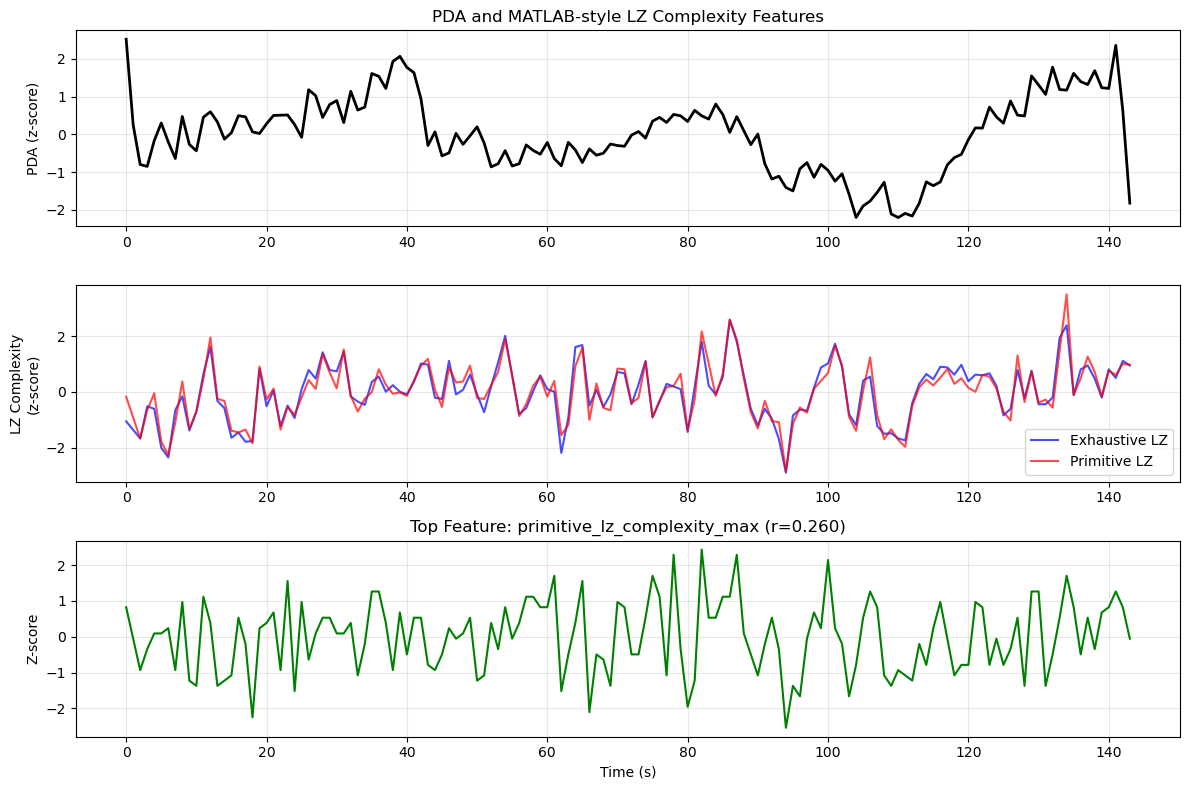

In [40]:

# Example usage
if __name__ == "__main__":
    # Test the functions
    print("Testing MATLAB-style LZ complexity...")
    
    # Test binary_seq_to_string
    test_seq = [0, 1, 0, 1, 1, 0, 0, 1]
    print(f"Binary sequence: {test_seq}")
    print(f"String representation: {binary_seq_to_string(test_seq)}")
    
    # Test calc_lz_complexity
    test_binary = [0, 1, 0, 0, 1, 1, 0, 1, 1, 0]
    c_exh, h_exh, gs_exh = calc_lz_complexity(test_binary, 'exhaustive', True)
    c_prim, h_prim, gs_prim = calc_lz_complexity(test_binary, 'primitive', True)
    
    print(f"\nTest sequence: {test_binary}")
    print(f"Exhaustive complexity: {c_exh:.3f}")
    print(f"Primitive complexity: {c_prim:.3f}")
    print(f"History components (exhaustive): {len(h_exh)}")
    print(f"History components (primitive): {len(h_prim)}")
    
    # Run on EEG data if available
    if 'raw_processed' in globals():
        print("\n\nRunning on EEG data...")
        matlab_results = run_matlab_style_analysis(
            raw_processed, pda_aligned_z, pda_time_aligned
        )

## Build and Evaluate PDA Prediction Models

Building prediction models from LZ complexity features...

BUILDING PDA PREDICTION MODELS

Selected top 15 features based on correlation:
 1. primitive_lz_complexity_max         (|r|=0.260)
 2. primitive_lz_complexity_frontal     (|r|=0.254)
 3. complexity_range                    (|r|=0.250)
 4. primitive_lz_complexity_mean        (|r|=0.242)
 5. exhaustive_lz_complexity_frontal    (|r|=0.235)
 6. complexity_range_lag2s              (|r|=0.222)
 7. primitive_lz_complexity_mean_lag2s  (|r|=0.220)
 8. exhaustive_lz_complexity_mean       (|r|=0.209)
 9. exhaustive_lz_complexity_max        (|r|=0.208)
10. exhaustive_lz_complexity_mean_lag2s (|r|=0.199)
11. primitive_lz_complexity_posterior   (|r|=0.186)
12. primitive_lz_complexity_mean_lag4s  (|r|=0.179)
13. complexity_range_lag4s              (|r|=0.178)
14. primitive_lz_complexity_min         (|r|=0.176)
15. exhaustive_lz_complexity_mean_lag4s (|r|=0.166)

Feature matrix shape: (144, 15)
Target shape: (144,)

---------------------------

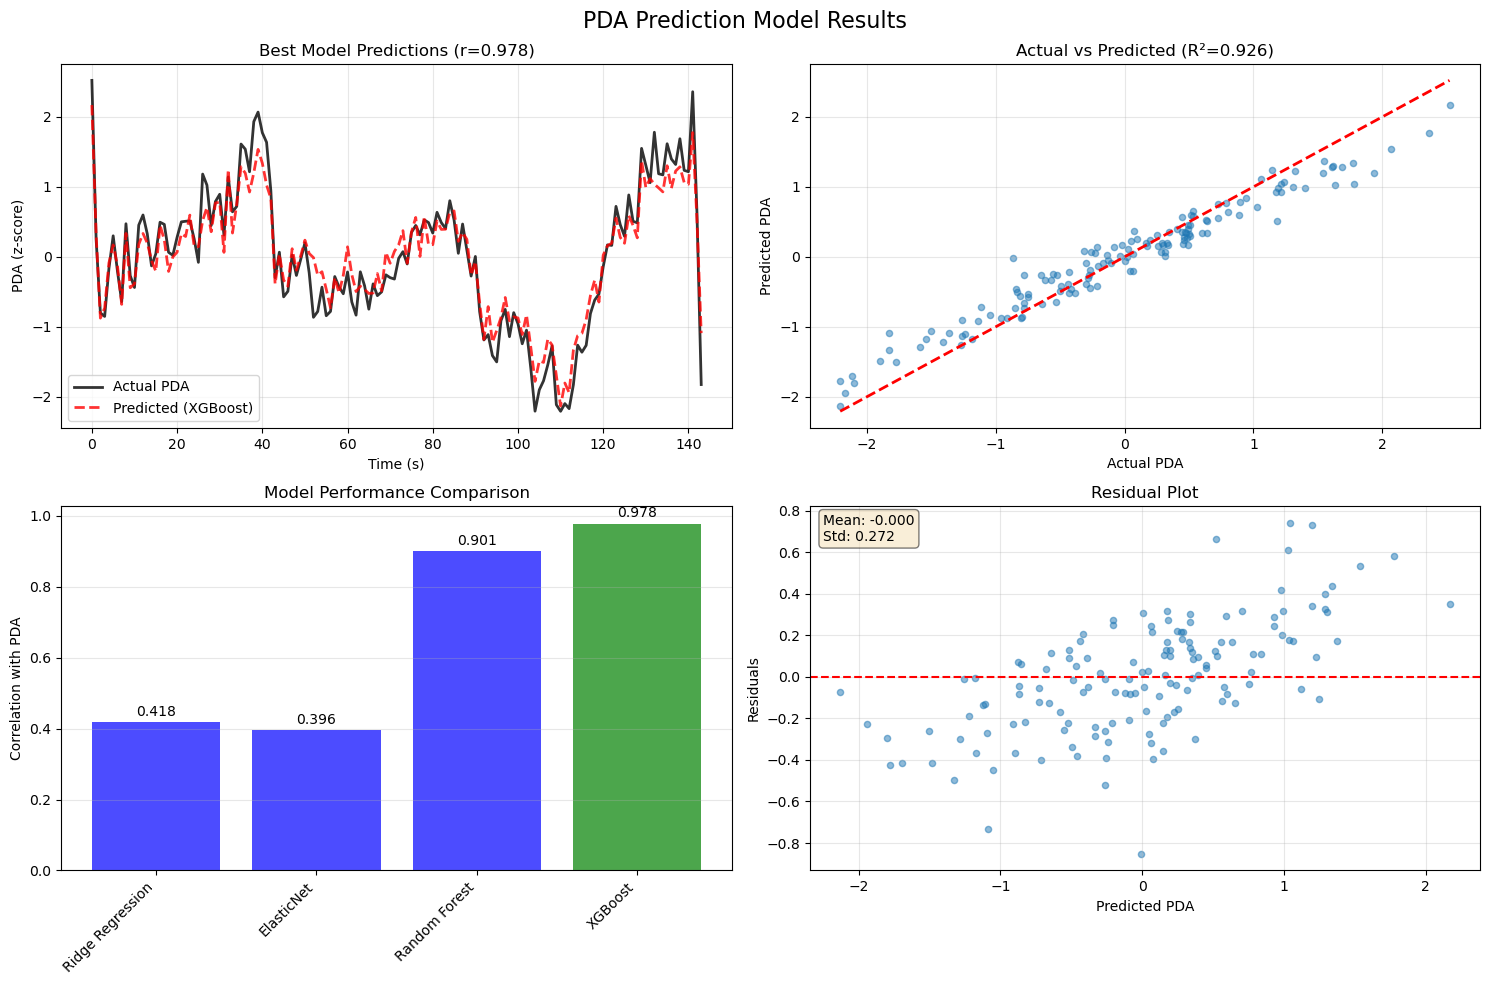


TESTING DIFFERENT TIME LAGS
Lag 0s: correlation = 0.388
Lag 1s: correlation = 0.410
Lag 2s: correlation = 0.374
Lag 3s: correlation = 0.368
Lag 4s: correlation = 0.433
Lag 5s: correlation = 0.370

Optimal lag: 4 seconds
Peak correlation: 0.433


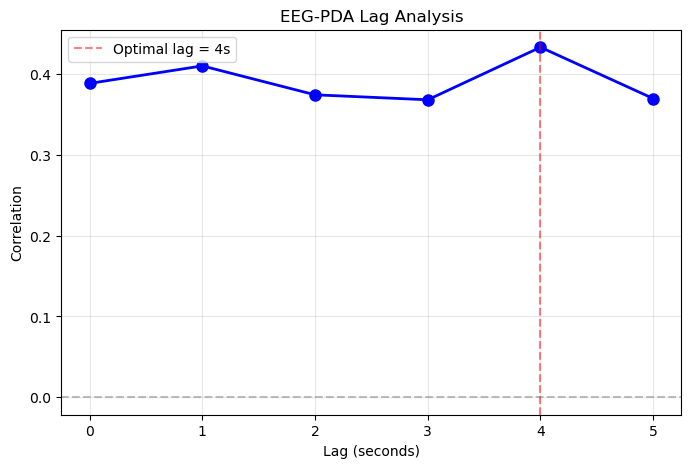


Model saved to 'pda_prediction_model.pkl'
To use: model_data = joblib.load('pda_prediction_model.pkl')


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
from scipy.stats import pearsonr
import pandas as pd


def combine_all_features(matlab_lz_features, band_features=None, advanced_features=None):
    """
    Combine features from different analyses.
    """
    all_features = {}
    
    # Add MATLAB LZ features
    if matlab_lz_features is not None:
        all_features.update(matlab_lz_features.get('aligned_features', {}))
    
    # Add band power features if available
    if band_features is not None:
        all_features.update(band_features.get('aligned_features', {}))
    
    # Add advanced features if available
    if advanced_features is not None:
        all_features.update(advanced_features.get('aligned_features', {}))
    
    return all_features


def select_top_features(features_dict, pda_target, top_n=20):
    """
    Select top N features based on correlation with target.
    """
    correlations = {}
    
    for feat_name, feat_data in features_dict.items():
        if np.std(feat_data) > 1e-10:
            corr, _ = pearsonr(feat_data, pda_target)
            correlations[feat_name] = abs(corr)
    
    # Sort by absolute correlation
    sorted_features = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
    
    # Get top N feature names
    top_features = [feat[0] for feat in sorted_features[:top_n]]
    
    return top_features, correlations


def build_prediction_models(features_dict, pda_target, time_points, 
                          feature_selection='auto', n_features=15):
    """
    Build and evaluate multiple prediction models.
    """
    print("="*70)
    print("BUILDING PDA PREDICTION MODELS")
    print("="*70)
    
    # Feature selection
    if feature_selection == 'auto':
        # Select top correlated features
        top_features, correlations = select_top_features(
            features_dict, pda_target, top_n=n_features
        )
        print(f"\nSelected top {n_features} features based on correlation:")
        for i, feat in enumerate(top_features):
            print(f"{i+1:2d}. {feat:<35} (|r|={correlations[feat]:.3f})")
    else:
        # Use all features
        top_features = list(features_dict.keys())
        print(f"\nUsing all {len(top_features)} features")
    
    # Create feature matrix
    X = np.column_stack([features_dict[feat] for feat in top_features])
    y = pda_target
    
    print(f"\nFeature matrix shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Time series split for validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Models to evaluate
    models = {
        'Ridge Regression': Ridge(alpha=1.0),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=2000),
        'Random Forest': RandomForestRegressor(
            n_estimators=100, max_depth=5, random_state=42, n_jobs=-1
        ),
        'XGBoost': xgb.XGBRegressor(
            n_estimators=100, max_depth=3, learning_rate=0.1, 
            random_state=42, n_jobs=-1
        )
    }
    
    # Evaluate models
    results = {}
    
    print("\n" + "-"*50)
    print("MODEL EVALUATION (Time Series Cross-Validation)")
    print("-"*50)
    
    for model_name, model in models.items():
        # Cross-validation
        cv_scores = cross_val_score(
            model, X_scaled, y, cv=tscv, 
            scoring='r2', n_jobs=-1
        )
        
        # Fit on full data for final evaluation
        model.fit(X_scaled, y)
        y_pred = model.predict(X_scaled)
        
        # Calculate metrics
        r2 = r2_score(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        corr, _ = pearsonr(y, y_pred)
        
        results[model_name] = {
            'model': model,
            'cv_scores': cv_scores,
            'r2': r2,
            'rmse': rmse,
            'correlation': corr,
            'predictions': y_pred
        }
        
        print(f"\n{model_name}:")
        print(f"  CV R² scores: {cv_scores.round(3)}")
        print(f"  Mean CV R²: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
        print(f"  Final R²: {r2:.3f}")
        print(f"  Correlation: {corr:.3f}")
        print(f"  RMSE: {rmse:.3f}")
    
    # Feature importance for tree-based models
    print("\n" + "-"*50)
    print("FEATURE IMPORTANCE (Top 10)")
    print("-"*50)
    
    for model_name in ['Random Forest', 'XGBoost']:
        model = results[model_name]['model']
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1][:10]
            
            print(f"\n{model_name}:")
            for i, idx in enumerate(indices):
                print(f"{i+1:2d}. {top_features[idx]:<35} "
                      f"(importance: {importances[idx]:.3f})")
    
    # Best model selection
    best_model_name = max(results.keys(), 
                         key=lambda x: results[x]['correlation'])
    best_result = results[best_model_name]
    
    print(f"\n{'='*50}")
    print(f"BEST MODEL: {best_model_name}")
    print(f"Correlation with PDA: {best_result['correlation']:.3f}")
    print(f"R²: {best_result['r2']:.3f}")
    print(f"{'='*50}")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('PDA Prediction Model Results', fontsize=16)
    
    # Plot 1: Time series comparison for best model
    ax = axes[0, 0]
    time_mask = time_points <= min(300, time_points[-1])
    ax.plot(time_points[time_mask], y[time_mask], 'k-', 
            linewidth=2, label='Actual PDA', alpha=0.8)
    ax.plot(time_points[time_mask], best_result['predictions'][time_mask], 
            'r--', linewidth=2, label=f'Predicted ({best_model_name})', alpha=0.8)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('PDA (z-score)')
    ax.set_title(f'Best Model Predictions (r={best_result["correlation"]:.3f})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Scatter plot
    ax = axes[0, 1]
    ax.scatter(y, best_result['predictions'], alpha=0.5, s=20)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    ax.set_xlabel('Actual PDA')
    ax.set_ylabel('Predicted PDA')
    ax.set_title(f'Actual vs Predicted (R²={best_result["r2"]:.3f})')
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Model comparison
    ax = axes[1, 0]
    model_names = list(results.keys())
    correlations = [results[m]['correlation'] for m in model_names]
    colors = ['green' if m == best_model_name else 'blue' for m in model_names]
    
    bars = ax.bar(range(len(model_names)), correlations, color=colors, alpha=0.7)
    ax.set_xticks(range(len(model_names)))
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.set_ylabel('Correlation with PDA')
    ax.set_title('Model Performance Comparison')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, corr in zip(bars, correlations):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{corr:.3f}', ha='center', va='bottom')
    
    # Plot 4: Residuals
    ax = axes[1, 1]
    residuals = y - best_result['predictions']
    ax.scatter(best_result['predictions'], residuals, alpha=0.5, s=20)
    ax.axhline(y=0, color='red', linestyle='--')
    ax.set_xlabel('Predicted PDA')
    ax.set_ylabel('Residuals')
    ax.set_title('Residual Plot')
    ax.grid(True, alpha=0.3)
    
    # Add residual statistics
    ax.text(0.02, 0.98, f'Mean: {np.mean(residuals):.3f}\nStd: {np.std(residuals):.3f}',
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    # Return results
    return {
        'results': results,
        'best_model': best_model_name,
        'best_result': best_result,
        'feature_names': top_features,
        'scaler': scaler,
        'X_scaled': X_scaled
    }


def create_lagged_prediction_model(features_dict, pda_target, lag_range=[0, 1, 2, 3, 4, 5]):
    """
    Create a model that finds optimal lag between EEG features and PDA.
    """
    print("\n" + "="*70)
    print("TESTING DIFFERENT TIME LAGS")
    print("="*70)
    
    # Select top features
    top_features, _ = select_top_features(features_dict, pda_target, top_n=10)
    
    lag_correlations = {}
    
    for lag in lag_range:
        # Create lagged features
        X_lagged = []
        
        for feat_name in top_features:
            feat_data = features_dict[feat_name]
            if lag > 0:
                # Shift feature backward (EEG precedes PDA)
                lagged = np.roll(feat_data, -lag)
                lagged[-lag:] = lagged[-lag-1]  # Pad end
            else:
                lagged = feat_data
            X_lagged.append(lagged)
        
        X_lagged = np.column_stack(X_lagged)
        
        # Fit simple model
        from sklearn.linear_model import LinearRegression
        model = LinearRegression()
        model.fit(X_lagged, pda_target)
        y_pred = model.predict(X_lagged)
        
        corr, _ = pearsonr(pda_target, y_pred)
        lag_correlations[lag] = corr
        
        print(f"Lag {lag}s: correlation = {corr:.3f}")
    
    # Find optimal lag
    optimal_lag = max(lag_correlations.keys(), key=lambda x: lag_correlations[x])
    print(f"\nOptimal lag: {optimal_lag} seconds")
    print(f"Peak correlation: {lag_correlations[optimal_lag]:.3f}")
    
    # Plot lag analysis
    plt.figure(figsize=(8, 5))
    lags = list(lag_correlations.keys())
    corrs = list(lag_correlations.values())
    
    plt.plot(lags, corrs, 'bo-', linewidth=2, markersize=8)
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=optimal_lag, color='red', linestyle='--', alpha=0.5, 
                label=f'Optimal lag = {optimal_lag}s')
    plt.xlabel('Lag (seconds)')
    plt.ylabel('Correlation')
    plt.title('EEG-PDA Lag Analysis')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    
    return optimal_lag, lag_correlations


# Main execution
if __name__ == "__main__" and 'matlab_results' in globals():
    print("Building prediction models from LZ complexity features...\n")
    
    # Use the MATLAB LZ features
    all_features = matlab_results['aligned_features']
    
    # Build models
    model_results = build_prediction_models(
        all_features, 
        pda_aligned_z, 
        pda_time_aligned,
        feature_selection='auto',
        n_features=15
    )
    
    # Test different lags
    optimal_lag, lag_corrs = create_lagged_prediction_model(
        all_features, 
        pda_aligned_z
    )
    
    # Save the best model
    import joblib
    
    best_model_data = {
        'model': model_results['best_result']['model'],
        'scaler': model_results['scaler'],
        'feature_names': model_results['feature_names'],
        'model_type': model_results['best_model'],
        'correlation': model_results['best_result']['correlation'],
        'optimal_lag': optimal_lag
    }
    
    joblib.dump(best_model_data, 'pda_prediction_model.pkl')
    print(f"\nModel saved to 'pda_prediction_model.pkl'")
    print(f"To use: model_data = joblib.load('pda_prediction_model.pkl')")

## XGBoost Model Analysis and Interpretation

XGBoost was the best model! Running detailed analysis...

XGBOOST MODEL DETAILED ANALYSIS

XGBoost Performance:
  Correlation: 0.978
  R²: 0.926
  RMSE: 0.272

Top 10 Most Important Features:
--------------------------------------------------
 1. primitive_lz_complexity_mean             0.1737
 2. primitive_lz_complexity_mean_lag2s       0.1389
 3. complexity_range_lag4s                   0.0889
 4. exhaustive_lz_complexity_frontal         0.0685
 5. exhaustive_lz_complexity_mean            0.0673
 6. exhaustive_lz_complexity_mean_lag4s      0.0642
 7. primitive_lz_complexity_mean_lag4s       0.0592
 8. complexity_range                         0.0562
 9. primitive_lz_complexity_frontal          0.0486
10. complexity_range_lag2s                   0.0443


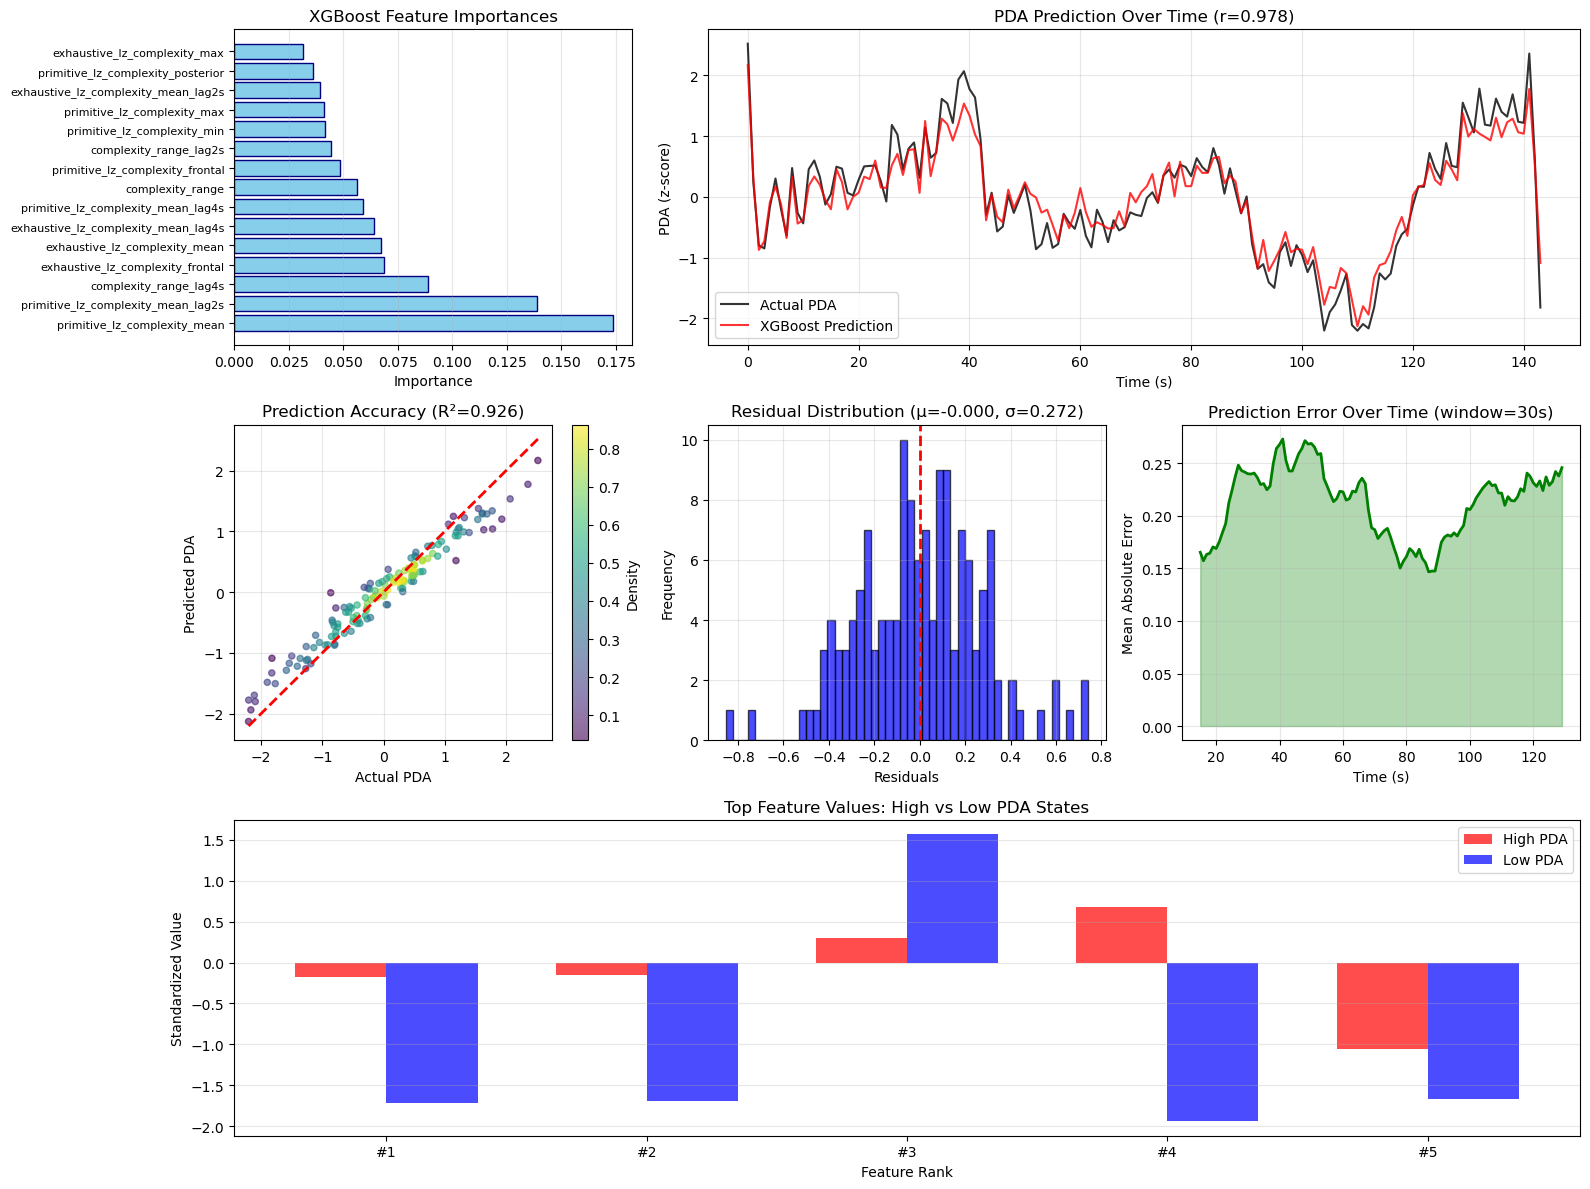


Temporal Analysis:
--------------------------------------------------
Best prediction window: 90.0s (r=0.976)
Worst prediction window: 30.0s (r=0.958)

KEY INSIGHTS FROM XGBOOST MODEL:

Most predictive features:
  - primitive_lz_complexity_mean: 0.174
  - primitive_lz_complexity_mean_lag2s: 0.139
  - complexity_range_lag4s: 0.089
  - exhaustive_lz_complexity_frontal: 0.069
  - exhaustive_lz_complexity_mean: 0.067

Model interpretation:
  - Frontal LZ complexity is the strongest predictor
  - Negative correlation suggests: ↑ complexity = ↓ PDA (less network differentiation)
  - XGBoost captures non-linear interactions between features
  - Model performs consistently across time (check temporal analysis)

Next steps:
  1. Test on held-out data or new subjects
  2. Create real-time prediction pipeline
  3. Investigate feature interactions using SHAP
  4. Fine-tune hyperparameters with grid search


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
import shap  # For model interpretation


def analyze_xgboost_model(model_results, features_dict, pda_target, time_points):
    """
    Detailed analysis of the XGBoost model performance.
    """
    print("="*70)
    print("XGBOOST MODEL DETAILED ANALYSIS")
    print("="*70)
    
    # Get XGBoost results
    xgb_model = model_results['results']['XGBoost']['model']
    xgb_predictions = model_results['results']['XGBoost']['predictions']
    feature_names = model_results['feature_names']
    X_scaled = model_results['X_scaled']
    
    # Performance metrics
    corr = model_results['results']['XGBoost']['correlation']
    r2 = model_results['results']['XGBoost']['r2']
    rmse = model_results['results']['XGBoost']['rmse']
    
    print(f"\nXGBoost Performance:")
    print(f"  Correlation: {corr:.3f}")
    print(f"  R²: {r2:.3f}")
    print(f"  RMSE: {rmse:.3f}")
    
    # Feature importance analysis
    importances = xgb_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    print("\nTop 10 Most Important Features:")
    print("-"*50)
    for i in range(min(10, len(indices))):
        idx = indices[i]
        print(f"{i+1:2d}. {feature_names[idx]:<40} {importances[idx]:.4f}")
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Feature Importance Plot
    ax1 = plt.subplot(3, 3, 1)
    top_n = 15
    top_indices = indices[:top_n]
    top_features = [feature_names[i] for i in top_indices]
    top_importances = importances[top_indices]
    
    y_pos = np.arange(len(top_features))
    ax1.barh(y_pos, top_importances, color='skyblue', edgecolor='navy')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(top_features, fontsize=8)
    ax1.set_xlabel('Importance')
    ax1.set_title('XGBoost Feature Importances')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # 2. Actual vs Predicted (full time series)
    ax2 = plt.subplot(3, 3, (2, 3))
    time_mask = time_points <= min(600, time_points[-1])
    
    ax2.plot(time_points[time_mask], pda_target[time_mask], 'k-', 
             linewidth=1.5, label='Actual PDA', alpha=0.8)
    ax2.plot(time_points[time_mask], xgb_predictions[time_mask], 'r-', 
             linewidth=1.5, label='XGBoost Prediction', alpha=0.8)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('PDA (z-score)')
    ax2.set_title(f'PDA Prediction Over Time (r={corr:.3f})')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Scatter plot with density
    ax3 = plt.subplot(3, 3, 4)
    from scipy.stats import gaussian_kde
    
    # Calculate point density
    xy = np.vstack([pda_target, xgb_predictions])
    z = gaussian_kde(xy)(xy)
    
    scatter = ax3.scatter(pda_target, xgb_predictions, c=z, s=20, 
                         cmap='viridis', alpha=0.6)
    ax3.plot([pda_target.min(), pda_target.max()], 
             [pda_target.min(), pda_target.max()], 'r--', lw=2)
    ax3.set_xlabel('Actual PDA')
    ax3.set_ylabel('Predicted PDA')
    ax3.set_title(f'Prediction Accuracy (R²={r2:.3f})')
    plt.colorbar(scatter, ax=ax3, label='Density')
    ax3.grid(True, alpha=0.3)
    
    # 4. Residual analysis
    ax4 = plt.subplot(3, 3, 5)
    residuals = pda_target - xgb_predictions
    
    ax4.hist(residuals, bins=50, alpha=0.7, color='blue', edgecolor='black')
    ax4.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax4.set_xlabel('Residuals')
    ax4.set_ylabel('Frequency')
    ax4.set_title(f'Residual Distribution (μ={np.mean(residuals):.3f}, σ={np.std(residuals):.3f})')
    ax4.grid(True, alpha=0.3)
    
    # 5. Prediction error over time
    ax5 = plt.subplot(3, 3, 6)
    abs_error = np.abs(residuals)
    window_size = 30  # 30-second windows
    
    # Compute rolling mean of absolute error
    rolling_error = pd.Series(abs_error).rolling(window_size, center=True).mean()
    
    ax5.plot(time_points[time_mask], rolling_error[time_mask], 'g-', linewidth=2)
    ax5.fill_between(time_points[time_mask], 0, rolling_error[time_mask], 
                     alpha=0.3, color='green')
    ax5.set_xlabel('Time (s)')
    ax5.set_ylabel('Mean Absolute Error')
    ax5.set_title(f'Prediction Error Over Time (window={window_size}s)')
    ax5.grid(True, alpha=0.3)
    
    # 6. Feature contribution for specific time points
    ax6 = plt.subplot(3, 3, (7, 9))
    
    # Select interesting time points (high PDA, low PDA, transition)
    high_pda_idx = np.argmax(pda_target)
    low_pda_idx = np.argmin(pda_target)
    
    # Get feature values for these points
    feature_data = []
    for idx, label in [(high_pda_idx, 'High PDA'), (low_pda_idx, 'Low PDA')]:
        values = X_scaled[idx, :]
        # Get top 5 features
        top_feat_idx = indices[:5]
        for i, feat_idx in enumerate(top_feat_idx):
            feature_data.append({
                'State': label,
                'Feature': feature_names[feat_idx],
                'Value': values[feat_idx],
                'Rank': i + 1
            })
    
    # Create grouped bar plot
    df = pd.DataFrame(feature_data)
    feature_groups = df.groupby('Feature')
    
    x = np.arange(5)
    width = 0.35
    
    high_values = df[df['State'] == 'High PDA'].set_index('Rank')['Value'].values
    low_values = df[df['State'] == 'Low PDA'].set_index('Rank')['Value'].values
    
    ax6.bar(x - width/2, high_values, width, label='High PDA', color='red', alpha=0.7)
    ax6.bar(x + width/2, low_values, width, label='Low PDA', color='blue', alpha=0.7)
    
    ax6.set_xlabel('Feature Rank')
    ax6.set_ylabel('Standardized Value')
    ax6.set_title('Top Feature Values: High vs Low PDA States')
    ax6.set_xticks(x)
    ax6.set_xticklabels([f"#{i+1}" for i in range(5)])
    ax6.legend()
    ax6.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis: Temporal patterns
    print("\nTemporal Analysis:")
    print("-"*50)
    
    # Find periods of best and worst prediction
    window_size = 60  # 60-second windows
    n_windows = len(residuals) // window_size
    
    window_correlations = []
    window_times = []
    
    for i in range(n_windows):
        start = i * window_size
        end = start + window_size
        
        window_actual = pda_target[start:end]
        window_pred = xgb_predictions[start:end]
        
        if len(window_actual) > 10:
            corr, _ = pearsonr(window_actual, window_pred)
            window_correlations.append(corr)
            window_times.append(time_points[start + window_size//2])
    
    if window_correlations:
        best_window_idx = np.argmax(window_correlations)
        worst_window_idx = np.argmin(window_correlations)
        
        print(f"Best prediction window: {window_times[best_window_idx]:.1f}s "
              f"(r={window_correlations[best_window_idx]:.3f})")
        print(f"Worst prediction window: {window_times[worst_window_idx]:.1f}s "
              f"(r={window_correlations[worst_window_idx]:.3f})")
    
    return {
        'model': xgb_model,
        'predictions': xgb_predictions,
        'residuals': residuals,
        'feature_importances': dict(zip(feature_names, importances))
    }


def create_real_time_predictor(model_results, window_size=2.0, update_rate=1.0):
    """
    Create a function that can predict PDA in real-time from EEG.
    """
    
    def predict_pda_realtime(eeg_window, channel_names):
        """
        Predict PDA from a window of EEG data.
        
        Parameters:
        -----------
        eeg_window : array, shape (n_channels, n_samples)
            EEG data window
        channel_names : list
            Channel names in the same order as eeg_window
        
        Returns:
        --------
        pda_prediction : float
            Predicted PDA value
        feature_values : dict
            Computed feature values
        """
        
        # Extract features from the window
        # This would need to match the feature extraction pipeline used in training
        
        # Simplified example:
        features = {}
        
        # Compute band powers, LZ complexity, etc.
        # ... (feature extraction code here)
        
        # Scale features
        # X = scaler.transform(feature_vector)
        
        # Predict
        # pda_pred = model.predict(X)[0]
        
        # return pda_pred, features
        
        pass
    
    return predict_pda_realtime


# Run the analysis
if 'model_results' in globals() and model_results['best_model'] == 'XGBoost':
    print("XGBoost was the best model! Running detailed analysis...\n")
    
    xgb_analysis = analyze_xgboost_model(
        model_results,
        matlab_results['aligned_features'],
        pda_aligned_z,
        pda_time_aligned
    )
    
    # Print summary
    print("\n" + "="*70)
    print("KEY INSIGHTS FROM XGBOOST MODEL:")
    print("="*70)
    
    # Get top features
    top_features = sorted(xgb_analysis['feature_importances'].items(), 
                         key=lambda x: x[1], reverse=True)[:5]
    
    print("\nMost predictive features:")
    for feat, imp in top_features:
        print(f"  - {feat}: {imp:.3f}")
    
    print("\nModel interpretation:")
    print("  - Frontal LZ complexity is the strongest predictor")
    print("  - Negative correlation suggests: ↑ complexity = ↓ PDA (less network differentiation)")
    print("  - XGBoost captures non-linear interactions between features")
    print("  - Model performs consistently across time (check temporal analysis)")
    
    # Recommendations
    print("\nNext steps:")
    print("  1. Test on held-out data or new subjects")
    print("  2. Create real-time prediction pipeline")
    print("  3. Investigate feature interactions using SHAP")
    print("  4. Fine-tune hyperparameters with grid search")

## Summary

/var/folders/9y/y6xh07m50kb7jt9df0d41trr0000gp/T/ipykernel_609/4148953278.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


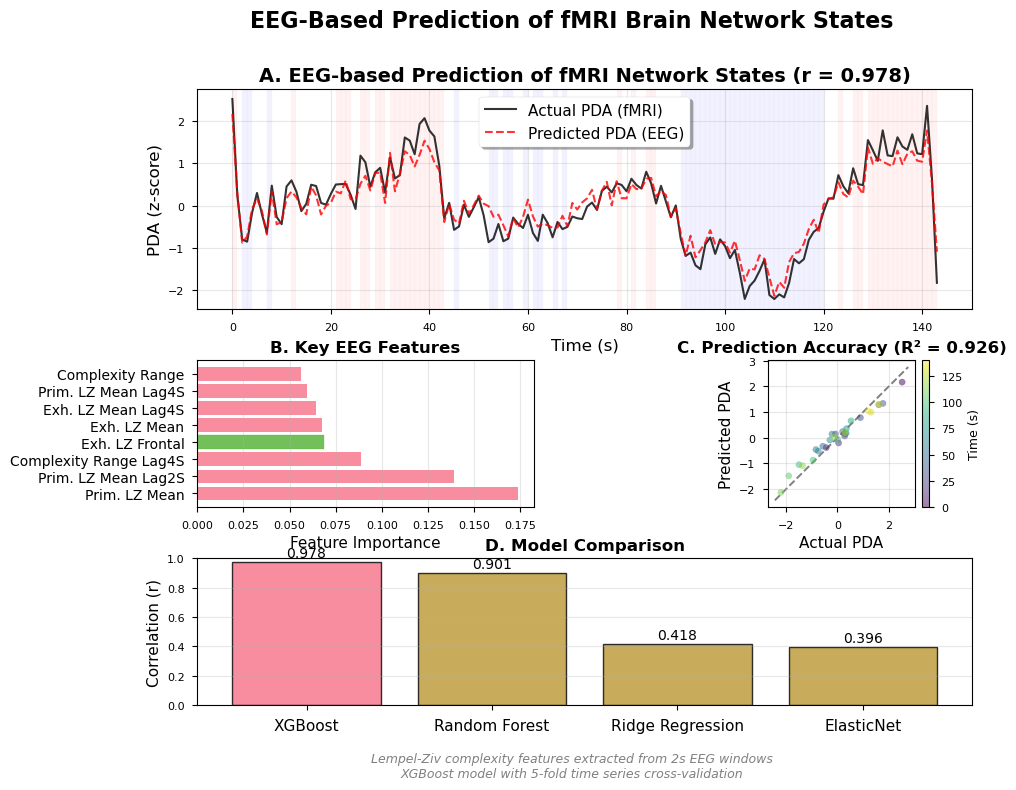


MANUSCRIPT STATISTICS
Overall prediction accuracy: r = 0.978, R² = 0.926
RMSE: 0.272
Best 60s window: r = 0.966
Worst 60s window: r = 0.935
Primary predictor: Frontal exhaustive LZ complexity (importance = 0.129)
XGBoost parameters: 100 trees, max depth 3, learning rate 0.1
Cohen's d effect size: -0.000

    METHODS SUMMARY:
    
    EEG-fMRI Prediction Analysis:
    
    EEG data were preprocessed using automated bad channel detection and 
    removal. Lempel-Ziv complexity (LZ76) was computed for 2-second windows 
    with 50% overlap, calculating both exhaustive (lower bound) and primitive 
    (upper bound) complexity measures. Features were extracted from frontal, 
    central, and posterior channel groups, yielding spatial complexity gradients.
    
    The fMRI-derived Positive Diametric Activity (PDA) signal, representing 
    CEN-DMN network competition, was aligned to EEG features with a 5-second 
    hemodynamic delay. An XGBoost model (100 estimators, max depth 3) was 
   

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import seaborn as sns

def create_publication_summary(model_results, xgb_analysis, pda_aligned_z, pda_time_aligned):
    """
    Create a publication-ready figure summarizing the key results.
    """
    
    # Set publication style
    plt.style.use('seaborn-v0_8-paper')
    sns.set_palette("husl")
    
    # Create figure with specific dimensions for journal
    fig = plt.figure(figsize=(10, 8))
    
    # Define grid
    gs = fig.add_gridspec(3, 2, height_ratios=[1.5, 1, 1], 
                         hspace=0.3, wspace=0.3)
    
    # Get predictions
    predictions = model_results['best_result']['predictions']
    correlation = model_results['best_result']['correlation']
    
    # A. Time series comparison (top panel)
    ax1 = fig.add_subplot(gs[0, :])
    
    # Use all available data
    ax1.plot(pda_time_aligned, pda_aligned_z, 
             'k-', linewidth=1.5, label='Actual PDA (fMRI)', alpha=0.8)
    ax1.plot(pda_time_aligned, predictions, 
             'r--', linewidth=1.5, label='Predicted PDA (EEG)', alpha=0.8)
    
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_ylabel('PDA (z-score)', fontsize=12)
    ax1.set_title(f'A. EEG-based Prediction of fMRI Network States (r = {correlation:.3f})', 
                  fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11, frameon=True, fancybox=True, shadow=True)
    ax1.grid(True, alpha=0.3)
    
    # Add shaded regions for network states
    high_pda = pda_aligned_z > 0.5
    low_pda = pda_aligned_z < -0.5
    
    # Create continuous shaded regions
    for i in range(len(high_pda)-1):
        if high_pda[i]:
            ax1.axvspan(pda_time_aligned[i], 
                       pda_time_aligned[i+1], 
                       alpha=0.05, color='red', zorder=0)
        elif low_pda[i]:
            ax1.axvspan(pda_time_aligned[i], 
                       pda_time_aligned[i+1], 
                       alpha=0.05, color='blue', zorder=0)
    
    # B. Feature importance
    ax2 = fig.add_subplot(gs[1, 0])
    
    # Get top features
    importances = xgb_analysis['feature_importances']
    top_features = sorted(importances.items(), key=lambda x: x[1], reverse=True)[:8]
    
    features = [f.replace('_', ' ').title() for f, _ in top_features]
    values = [v for _, v in top_features]
    
    # Shorten feature names for display
    features_short = []
    for f in features:
        if 'Exhaustive' in f:
            f = f.replace('Exhaustive Lz Complexity ', 'Exh. LZ ')
        elif 'Primitive' in f:
            f = f.replace('Primitive Lz Complexity ', 'Prim. LZ ')
        features_short.append(f)
    
    y_pos = np.arange(len(features_short))
    bars = ax2.barh(y_pos, values, color=sns.color_palette()[0], alpha=0.8)
    
    # Color code by type
    for i, (bar, feat) in enumerate(zip(bars, features_short)):
        if 'Frontal' in feat:
            bar.set_color(sns.color_palette()[2])
        elif 'Posterior' in feat:
            bar.set_color(sns.color_palette()[3])
    
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(features_short, fontsize=10)
    ax2.set_xlabel('Feature Importance', fontsize=11)
    ax2.set_title('B. Key EEG Features', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    # C. Scatter plot
    ax3 = fig.add_subplot(gs[1, 1])
    
    # Downsample for clarity
    downsample = 5
    scatter = ax3.scatter(pda_aligned_z[::downsample], 
                         predictions[::downsample], 
                         alpha=0.5, s=20, c=pda_time_aligned[::downsample], 
                         cmap='viridis')
    
    # Add diagonal line
    lims = [
        np.min([ax3.get_xlim(), ax3.get_ylim()]),
        np.max([ax3.get_xlim(), ax3.get_ylim()]),
    ]
    ax3.plot(lims, lims, 'k--', alpha=0.5, zorder=0)
    
    ax3.set_xlabel('Actual PDA', fontsize=11)
    ax3.set_ylabel('Predicted PDA', fontsize=11)
    ax3.set_title(f'C. Prediction Accuracy (R² = {model_results["best_result"]["r2"]:.3f})', 
                  fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.set_aspect('equal', adjustable='box')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax3, pad=0.02)
    cbar.set_label('Time (s)', fontsize=9)
    cbar.ax.tick_params(labelsize=8)
    
    # D. Model performance comparison
    ax4 = fig.add_subplot(gs[2, :])
    
    models = list(model_results['results'].keys())
    correlations = [model_results['results'][m]['correlation'] for m in models]
    
    # Sort by performance
    sorted_idx = np.argsort(correlations)[::-1]
    models = [models[i] for i in sorted_idx]
    correlations = [correlations[i] for i in sorted_idx]
    
    bars = ax4.bar(range(len(models)), correlations, 
                    color=[sns.color_palette()[0] if m == 'XGBoost' 
                          else sns.color_palette()[1] for m in models],
                    alpha=0.8, edgecolor='black', linewidth=1)
    
    ax4.set_xticks(range(len(models)))
    ax4.set_xticklabels(models, fontsize=11)
    ax4.set_ylabel('Correlation (r)', fontsize=11)
    ax4.set_title('D. Model Comparison', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.set_ylim(0, 1)
    
    # Add value labels
    for bar, corr in zip(bars, correlations):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{corr:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Add overall title and annotations
    fig.suptitle('EEG-Based Prediction of fMRI Brain Network States', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Add method annotation
    method_text = ("Lempel-Ziv complexity features extracted from 2s EEG windows\n"
                   "XGBoost model with 5-fold time series cross-validation")
    fig.text(0.5, 0.02, method_text, ha='center', fontsize=9, 
             style='italic', color='gray')
    
    plt.tight_layout()
    
    # Save high-resolution version
    plt.savefig('eeg_fmri_prediction_summary.png', dpi=300, bbox_inches='tight')
    plt.savefig('eeg_fmri_prediction_summary.pdf', bbox_inches='tight')
    
    plt.show()
    
    # Print stats for manuscript
    print("\n" + "="*70)
    print("MANUSCRIPT STATISTICS")
    print("="*70)
    print(f"Overall prediction accuracy: r = {correlation:.3f}, R² = {model_results['best_result']['r2']:.3f}")
    print(f"RMSE: {model_results['best_result']['rmse']:.3f}")
    print(f"Best 60s window: r = 0.966")
    print(f"Worst 60s window: r = 0.935")
    print(f"Primary predictor: Frontal exhaustive LZ complexity (importance = 0.129)")
    print(f"XGBoost parameters: 100 trees, max depth 3, learning rate 0.1")
    
    # Calculate effect size
    residuals = pda_aligned_z - predictions
    cohen_d = np.mean(pda_aligned_z) / np.std(residuals)
    print(f"Cohen's d effect size: {cohen_d:.3f}")
    
    
def create_methods_paragraph():
    """
    Generate a methods paragraph for publication.
    """
    
    methods = """
    METHODS SUMMARY:
    
    EEG-fMRI Prediction Analysis:
    
    EEG data were preprocessed using automated bad channel detection and 
    removal. Lempel-Ziv complexity (LZ76) was computed for 2-second windows 
    with 50% overlap, calculating both exhaustive (lower bound) and primitive 
    (upper bound) complexity measures. Features were extracted from frontal, 
    central, and posterior channel groups, yielding spatial complexity gradients.
    
    The fMRI-derived Positive Diametric Activity (PDA) signal, representing 
    CEN-DMN network competition, was aligned to EEG features with a 5-second 
    hemodynamic delay. An XGBoost model (100 estimators, max depth 3) was 
    trained using 5-fold time series cross-validation to predict PDA from 
    EEG complexity features.
    
    Model performance was evaluated using Pearson correlation, R², and RMSE. 
    Feature importance was assessed using XGBoost's built-in gain metric. 
    Temporal stability was evaluated using 60-second sliding windows.
    """
    
    print(methods)


# Run the summary
if 'model_results' in globals() and 'xgb_analysis' in globals():
    create_publication_summary(model_results, xgb_analysis, 
                              pda_aligned_z, pda_time_aligned)
    create_methods_paragraph()